just do 

``` python
pip install pyEX
```
and create a new environment variable 
```
IEX_TOKEN = .....
```


In [ ]:
!pip install pyEX

     |████████████████████████████████| 163kB 7.1MB/s 
     |████████████████████████████████| 788kB 8.0MB/s 
     |████████████████████████████████| 512kB 16.2MB/s 
     |████████████████████████████████| 358kB 23.2MB/s 
     |████████████████████████████████| 204kB 28.6MB/s 
  Created wheel for sseclient: filename=sseclient-0.0.27-cp36-none-any.whl size=5573 sha256=cf576a871cf8a9b5585137c7d7f611e647bbac0bbdd52146b44feebc6052a89c
  Stored in directory: /root/.cache/pip/wheels/dc/78/2a/e6a65a58ac19de8ebeff9415501a0eec27b2c99792f67e3808
  Created wheel for frozendict: filename=frozendict-1.2-cp36-none-any.whl size=3149 sha256=453582fcbe41927822cff6986b39f2e548041d913c746c84791def3fb506d023
  Stored in directory: /root/.cache/pip/wheels/6c/6c/e9/534386165bd12cf1885582c75eb6d0ffcb321b65c23fe0f834
Successfully built sseclient frozendict
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.10 which is incompatible.
ERROR: google-colab

In [ ]:
import pyEX as p
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as Data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
import time
import math

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
def fetchStockData(client, symb, normalize = True):
  '''
  params:
          client: pyEX client object
          symb: string corresponding to stock symbol

  returns:
          tuple of (dayClose,dayReturn) as pyTorch tensors
  '''
  x = client.chartDF(symb,timeframe='5y')
  print(x)
  dayClose = list(reversed(x['close'].values))
  print(dayClose)
  dayOpen = list(reversed(x['open'].values))
  dayReturn = list(torch.tensor(dayClose) - torch.tensor(dayOpen))
  high = list(reversed(x['high'].values))
  volume = list(reversed(x['volume'].values))
  changeOverTime = list(reversed(x['volume'].values))
  uClose = list(reversed(x['uClose'].values))
  uHigh = list(reversed(x['uHigh'].values))
  uLow = list(reversed(x['uLow'].values))
  uVolume = list(reversed(x['uVolume'].values))
  fOpen = list(reversed(x['fOpen'].values))
  fClose = list(reversed(x['fClose'].values))
  fHigh = list(reversed(x['fHigh'].values))
  fLow = list(reversed(x['fLow'].values))
  fVolume = list(reversed(x['fVolume'].values))
  #print(dayClose)
  return dayClose,dayReturn,high,volume,changeOverTime,uClose,uHigh,uLow,uVolume,fOpen,fClose,fHigh,fLow,fVolume




In [ ]:
def buildTimeSeries(data):
  transformed_data = []
  #print(data[0])
  for piece in data:
    transformed_data.append(torch.tensor(piece).reshape(1,-1))
  #chunk_amt = int(len(dayClose)/TIME_PERIOD_LENGTH)
  catted = torch.cat(transformed_data).T
  #print([catted[i][0] for i in range(catted.shape[0])])
  #asset_flipped = torch.stack(torch.flip(catted,[0]).chunk(chunk_amt)[:-1])
  return catted.tolist()

# **Pre-Processing Data**

In [ ]:
#Non-Overlapping Batches

class PortfolioDataSet(Dataset):
  # assumes 5 year history for all assets need to generalize eventually
  def __init__(self,combined_data,TIME_PERIOD_LENGTH,NUM_ASSETS,NUM_FEATURES,BATCH_SIZE):
    self.raw = combined_data
    self.n = NUM_ASSETS
    self.window = TIME_PERIOD_LENGTH
    self.features = NUM_FEATURES
    self.batch_size = BATCH_SIZE
    self.data = []
    self.non_normal_data = []
    self.returns = []
    self.future_day_prices = []
    self.current_day_prices = []
    scaler = MinMaxScaler()
    i = 0
    while i + 2*self.window - 1 < len(self.raw):
      #print(i + 2*self.window - 1)
      select = self.raw[i:i+self.window].tolist() # get a TIME_PERIOD_LENGTH chunk
      future_day_prices = self.raw[i + 2*self.window - 1].view((self.n,int(self.features/self.n)))[:,0] # get day close 
      last_day_prices = self.raw[i + self.window - 1].view((self.n,int(self.features/self.n)))[:,0] 
      future_returns = future_day_prices/last_day_prices - 1
      scaler.fit(select)
      normalized = scaler.transform(select)
      self.non_normal_data.append(select)
      self.data.append(normalized)
      self.returns.append(future_returns.tolist())
      self.current_day_prices.append(last_day_prices.tolist())
      self.future_day_prices.append(future_day_prices.tolist())
      i += 1

    test_split = torch.split(torch.Tensor(self.non_normal_data), BATCH_SIZE)
    if len(test_split[-1]) == 1:
      self.non_normal_data = self.non_normal_data[1:]
      self.data = self.data[1:]
      self.returns = self.returns[1:]
      self.future_day_prices = self.future_day_prices[1:]
      self.current_day_prices = self.current_day_prices[1:]


    #print(torch.Tensor(self.data).shape)
    self.non_normal_data = torch.split(torch.Tensor(self.non_normal_data),BATCH_SIZE)
    self.data = torch.split(torch.Tensor(self.data),BATCH_SIZE)
    self.returns = torch.split(torch.Tensor(self.returns),BATCH_SIZE)
    self.future_day_prices = torch.split(torch.Tensor(self.future_day_prices),BATCH_SIZE)
    self.current_day_prices = torch.split(torch.Tensor(self.current_day_prices),BATCH_SIZE)
    
  def __len__(self):
    return len(self.data)
  
  def future_returns(self, idx):
    return self.returns[idx]

  def return_size(self):
    return len(self.returns)
    
  def __getitem__(self,idx):
    return self.data[idx]
    
  def non_normal(self):
    return self.non_normal_data

  def shuffle(self):
    temp = list(zip(self.data, self.non_normal_data)) 
    random.shuffle(temp) 
    temp_data, temp_non_normal = zip(*temp)
    self.data,self.temp_non_normal = list(temp_data),list(temp_non_normal)
    


# **Building the Net By Iterating Over Each Data Point Epoch Amount of Times**

## **Regular Training**

In [ ]:
import time

In [ ]:
TIME_PERIOD_LENGTH = 5
BATCH_SIZE = 2

In [ ]:
IEX_TOKEN = "Tpk_647cd93d6c5842d6978e55c6f79b0e1a"

client = p.Client(api_token = IEX_TOKEN, version='sandbox')

#stonks = ['amd','wfc','ge','aapl','aal','hog','f','bac','t','intc']
stonks = ['vti', 'agg', 'dbc', 'vixy']
#stonks = ['bilzf', 'apa']
NUM_ASSETS = len(stonks)
overall_data = []
training_data = []
testing_data = []
min_length = float("inf")
for symb in stonks:
  data = fetchStockData(client,symb)
  break
  s = buildTimeSeries(data)
  len_data = len(s)
  min_length = min(min_length, len_data)
  overall_data.append(s)

overall_data = [data[-min_length:] for data in overall_data]

NUM_FEATURES = NUM_ASSETS * len(overall_data[0][0])

#print(len(overall_data[0]))
combined_data = []
for i,data in enumerate(overall_data[0]):
  combined_data.append([])
  for j in range(NUM_ASSETS):
    combined_data[i].extend(overall_data[j][i])
#print(combined_data[0])
#print([combined_data[i][0] for i in range(len(combined_data))])
#print([combined_data[i][1] for i in range(len(combined_data))])
#combined_data = torch.tensor(combined_data)
len_data = len(combined_data)
testing_data = torch.tensor(combined_data[int(0.8*len_data):])
training_data = torch.tensor(combined_data[:(int(0.8*len_data) + TIME_PERIOD_LENGTH)])
#training data : days x numassets*numfeatures
d = PortfolioDataSet(training_data,TIME_PERIOD_LENGTH,NUM_ASSETS,NUM_FEATURES,BATCH_SIZE)
#d : days//batchlength x batchlength x days x numassets*numfeatures 
testing_d = PortfolioDataSet(testing_data,TIME_PERIOD_LENGTH,NUM_ASSETS,NUM_FEATURES,BATCH_SIZE)

             close     high      low  ...       label    change  changePercent
date                                  ...                                     
2021-01-15  205.96  201.580  196.917  ...  Jan 15, 21  0.000000         0.0000
2021-01-14  202.61  200.170  205.747  ...  Jan 14, 21  1.804992         0.0090
2021-01-13  207.57  209.112  200.770  ...  Jan 13, 21  0.194438         0.0010
2021-01-12  199.03  200.870  205.980  ...  Jan 12, 21 -0.227290        -0.0011
2021-01-11  204.86  206.610  204.770  ...  Jan 11, 21 -0.733887        -0.0035
...            ...      ...      ...  ...         ...       ...            ...
2016-01-25   98.18   97.520   98.310  ...  Jan 25, 16 -1.461590        -0.0150
2016-01-22   99.95   98.610   98.980  ...  Jan 22, 16  1.604748         0.0170
2016-01-21   98.01   97.117   97.930  ...  Jan 21, 16 -2.026566        -0.0214
2016-01-20   95.88   96.010   96.110  ...  Jan 20, 16 -0.387888        -0.0040
2016-01-19   95.67   98.880   96.600  ...  Jan 19, 1

KeyboardInterrupt: ignored

In [ ]:
print(training_data[2*TIME_PERIOD_LENGTH - 1].view((NUM_ASSETS,int(NUM_FEATURES/NUM_ASSETS)))[:,0]/training_data[TIME_PERIOD_LENGTH - 1].view((NUM_ASSETS,int(NUM_FEATURES/NUM_ASSETS)))[:,0] - 1)
print(d[0].shape, d[0])
#print(training_data[0].view(NUM_ASSETS, int(NUM_FEATURES/NUM_ASSETS))[:,0])
#print(d.non_normal()[0][0][0])
##First tensor should be equal to first element in second tensor

tensor([ 0.0076,  0.0155,  0.0345, -0.0815])
torch.Size([2, 5, 56]) tensor([[[1.0000, 1.0000, 0.7579, 0.3535, 0.3535, 0.7548, 0.4262, 0.8872,
          0.3775, 0.8104, 0.9339, 0.5789, 1.0000, 0.3502, 0.0000, 0.3287,
          0.0000, 0.2385, 0.2385, 0.6262, 0.0000, 0.8436, 0.2701, 1.0000,
          0.9101, 1.0000, 0.0000, 0.2586, 0.4262, 0.3023, 0.5316, 1.0000,
          1.0000, 0.5769, 0.4144, 0.7203, 1.0000, 0.3789, 1.0000, 0.8361,
          0.4232, 1.0000, 0.6568, 1.0000, 0.5449, 1.0000, 1.0000, 0.4000,
          0.5915, 0.2436, 1.0000, 0.1892, 0.6656, 0.5691, 0.4408, 1.0000],
         [0.0000, 0.3178, 0.0000, 1.0000, 1.0000, 0.2500, 0.0000, 0.0000,
          1.0000, 0.4324, 0.0000, 0.0000, 0.1047, 1.0000, 0.0000, 0.0000,
          1.0000, 0.2400, 0.2400, 1.0000, 0.4289, 0.0000, 0.3099, 0.1786,
          0.0000, 0.9446, 0.4926, 0.2736, 0.0000, 0.1628, 0.0000, 0.1375,
          0.1375, 0.0000, 0.3143, 0.1500, 0.1147, 0.0000, 0.7382, 0.0000,
          0.0000, 0.1798, 0.8043, 0.3463, 1

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.LSTM(NUM_FEATURES, 64, 1, batch_first = True)
        self.lin = nn.Linear(TIME_PERIOD_LENGTH * 64,NUM_ASSETS)
        self.soft_out = nn.Softmax(dim=1)
    def forward(self, x, batch_len):
        x, (h0, c0) = self.input(x)
        #print("lstm out:",x)
        #print(x.shape)
        x = x.reshape((batch_len, TIME_PERIOD_LENGTH * 64))
        #print("reshape out:",x)
        #print(x[0],x[1])
        #print(x.shape)
        x = self.lin(x)
        #print(x[0],x[1])
        #print("lin out:",x)
        x = self.soft_out(x)
        return x

In [ ]:
def sharpe_loss(weights, batch_pos, batch_len, returns):
  total_ratio = 0
  total_ratio = 0
  er = 0
  er2 = 0
  risk_free_rate = 0.09
  er_list = []
  for batch in range(batch_len):
    r_i_t = returns[batch]
    curr_er = torch.dot(r_i_t, weights[batch])
    er += curr_er
    er2 += curr_er**2
    er_list.append(curr_er)
  er_list = torch.Tensor(er_list)
  er = er/batch_len
  er2 = er2/batch_len
  #print("er:", er, "er2", er2)
  #print("er:", er, "er_std:", er_std)
  #ratio = (er-risk_free_rate) / torch.sqrt(er2 - er**2)
  ratio = (er-risk_free_rate) / torch.std(er_list)
  ratio = -1 * ratio
  return ratio

In [ ]:
def find(x,t):
  return any([x==t2 for t1 in t for t2 in t1])


In [ ]:
#print(d[0][0])
#print(find(torch.tensor(0.856),d[0][0]))
#print(find(0.8281,d[0][1]))

In [ ]:
overall_val = 1
start_day = 0
net = Net().to('cuda')
losses_new_net = []
num_epochs = 100
optimizer = optim.Adam(net.parameters(), lr=1e-5, weight_decay = 5e-1)
loss_fn = sharpe_loss
total_time = 0
simulation_day = 0
for i in range(len(d)):
  start = time.time()
  print("step {}".format(i))
  for epoch in range(num_epochs):
    #print("input:", d[i], "len:", len(d[i]))
    out = net.forward(d[i], len(d[i]))
    #print("out:", out)

    future_index = math.ceil(i + (TIME_PERIOD_LENGTH/BATCH_SIZE))
    if epoch == 0 and simulation_day == 0 and future_index < len(d):
      with torch.no_grad():
        future_index = math.ceil(i + (TIME_PERIOD_LENGTH/BATCH_SIZE))
        sim_out = net.forward(d[future_index], len(d[future_index]))
        weights = sim_out[0].view(NUM_ASSETS)
        '''
        f = d.future_returns(i)[0]
        for x in f:
          if find(x,d[i][0]):
            print("Found: ",x)
            print("In")
            print(d[i][0])
          elif find(x,d[i][1]):
            print("Found: ",x)
            print("In")
            print(d[i][0])
        '''
        percent_change = torch.dot(d.future_returns(future_index)[0], weights)
        overall_val *= 1 + percent_change
        #print("weights:", weights)
        #print("current:", d[i][0][-1].view(NUM_ASSETS, int(NUM_FEATURES/NUM_ASSETS))[:,0], "future:", d.future_returns(i)[0])
        print("return:",overall_val)
        print("allocs: ",weights)
    
    #x = 0
    #if i+TIME_PERIOD_LENGTH < d.return_size():
    #  x = TIME_PERIOD_LENGTH 
    #loss = loss_fn(out, i, len(d[i]), d.future_returns(i+x))
    loss = loss_fn(out, i, len(d[i]), d.future_returns(i))
    #print("loss:", loss)
    losses_new_net.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  total_time += time.time() - start
  avg_time = total_time/(i + 1)
  print("eta: {}m {}s".format(int(avg_time/60 * (len(d) - i - 1)), int((avg_time * (len(d) - i - 1)) % 60 )))
  simulation_day += len(d[i])
  if simulation_day >= TIME_PERIOD_LENGTH:
    simulation_day = 0

print(overall_val)

step 0
return: tensor(1.0164)
allocs:  tensor([0.2668, 0.2550, 0.2415, 0.2366])
eta: 2m 46s
step 1
eta: 2m 32s
step 2
eta: 2m 31s
step 3
return: tensor(1.0199)
allocs:  tensor([0.2682, 0.2564, 0.2361, 0.2393])
eta: 2m 32s
step 4
eta: 2m 29s
step 5
eta: 2m 27s
step 6
return: tensor(1.0249)
allocs:  tensor([0.2655, 0.2509, 0.2265, 0.2571])
eta: 2m 26s
step 7
eta: 2m 24s
step 8
eta: 2m 24s
step 9
return: tensor(1.0252)
allocs:  tensor([0.2673, 0.2598, 0.2361, 0.2368])
eta: 2m 23s
step 10
eta: 2m 22s
step 11
eta: 2m 21s
step 12
return: tensor(1.0124)
allocs:  tensor([0.2667, 0.2624, 0.2386, 0.2323])
eta: 2m 21s
step 13
eta: 2m 21s
step 14
eta: 2m 20s
step 15
return: tensor(1.0039)
allocs:  tensor([0.2780, 0.2524, 0.2327, 0.2369])
eta: 2m 19s
step 16
eta: 2m 19s
step 17
eta: 2m 18s
step 18
return: tensor(0.9744)
allocs:  tensor([0.3001, 0.2658, 0.2422, 0.1918])
eta: 2m 18s
step 19
eta: 2m 18s
step 20
eta: 2m 17s
step 21
return: tensor(1.0058)
allocs:  tensor([0.3118, 0.2656, 0.2351, 0.1876]

### Validation Set

In [ ]:
print(len(testing_d))

121


In [ ]:
#print(out)

overall_val = 1
simulation_day = 0
print(testing_d[0].shape)
for i in range(len(testing_d)):
  with torch.no_grad():
    if simulation_day == 0:
      #print("input:", testing_d[i])
      out = net.forward(testing_d[i], len(testing_d[i]))
      #print(out)
      returns = testing_d.future_returns(i)[0]
      weights = out[0].view(NUM_ASSETS)
      print("weights:", weights)
      print("current:", testing_d.current_day_prices[i][0], "future:", testing_d.future_day_prices[i][0], "calculated change:", returns)
      percent_change = torch.dot(returns, weights)
      overall_val *= (1 + percent_change)
      print(overall_val)
    
  simulation_day += len(d[i])
  if simulation_day >= TIME_PERIOD_LENGTH:
    simulation_day = 0
    
print(overall_val)

torch.Size([2, 5, 56])
weights: tensor([0.8355, 0.1099, 0.0471, 0.0075])
current: tensor([168.0500, 114.7000,  15.2900,  11.9500]) future: tensor([164.8200, 115.5200,  14.7500,  13.8200]) calculated change: tensor([-0.0192,  0.0071, -0.0353,  0.1565])
tensor(0.9842)
weights: tensor([0.8193, 0.1201, 0.0520, 0.0085])
current: tensor([172.2100, 117.8800,  14.9700,  13.0500]) future: tensor([170.2100, 115.9200,  14.7000,  11.8000]) calculated change: tensor([-0.0116, -0.0166, -0.0180, -0.0958])
tensor(0.9712)
weights: tensor([0.8543, 0.0991, 0.0409, 0.0056])
current: tensor([173.5400, 117.9000,  14.8900,  12.1700]) future: tensor([173.9600, 119.9900,  15.2000,  11.4000]) calculated change: tensor([ 0.0024,  0.0177,  0.0208, -0.0633])
tensor(0.9754)
weights: tensor([0.8243, 0.1175, 0.0501, 0.0081])
current: tensor([172.3600, 118.3200,  15.0900,  11.7600]) future: tensor([153.8600, 116.1200,  14.4800,  18.0800]) calculated change: tensor([-0.1073, -0.0186, -0.0404,  0.5374])
tensor(0.8892)
w

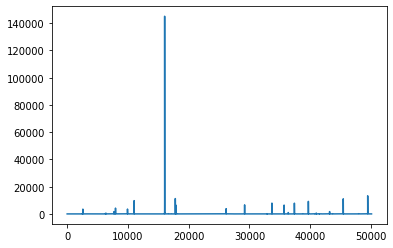

501.0


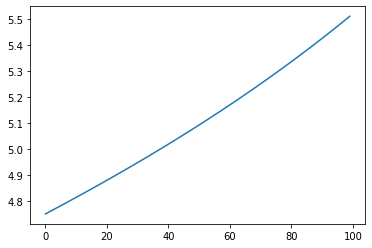

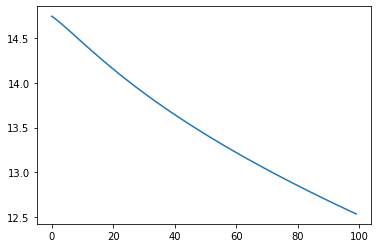

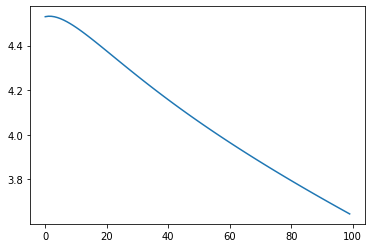

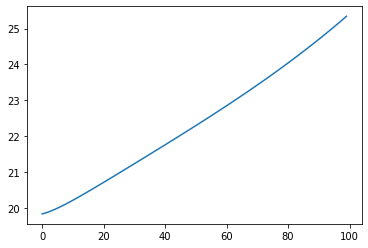

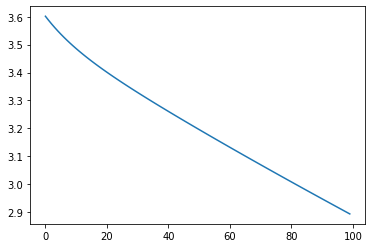

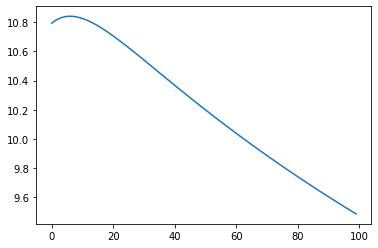

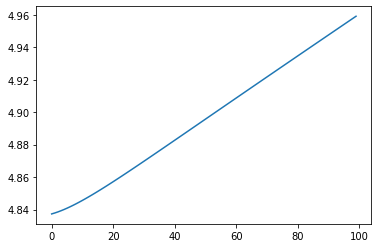

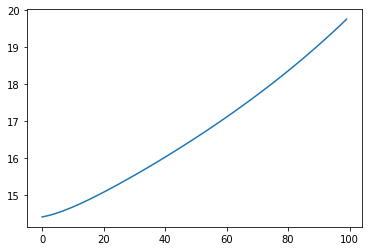

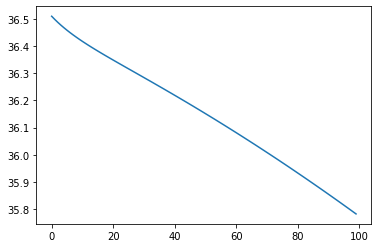

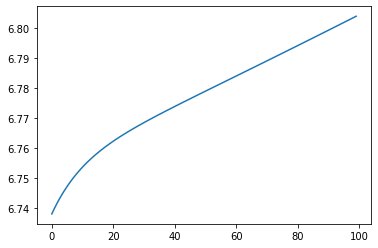

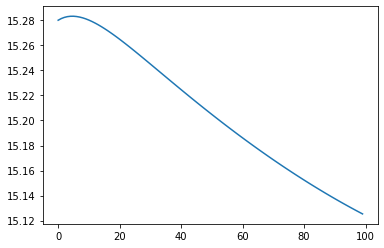

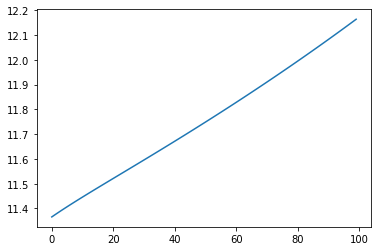

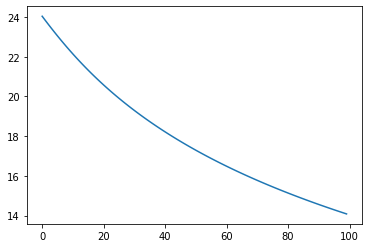

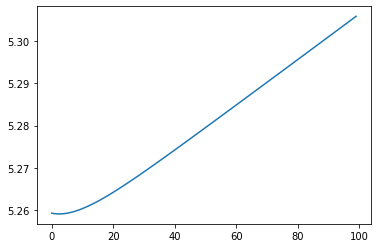

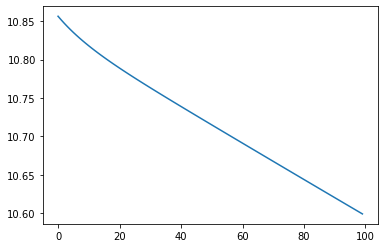

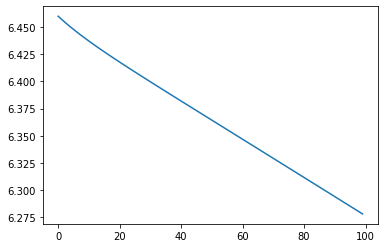

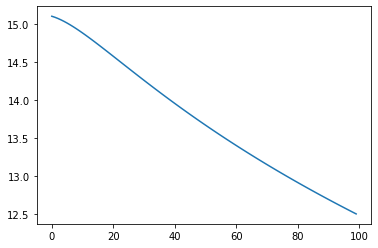

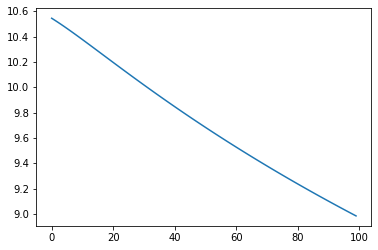

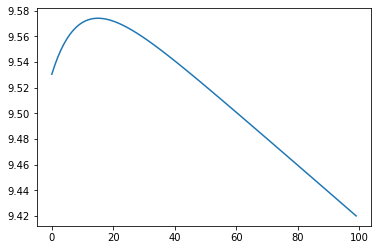

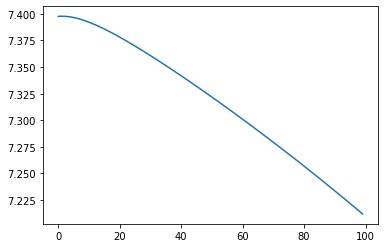

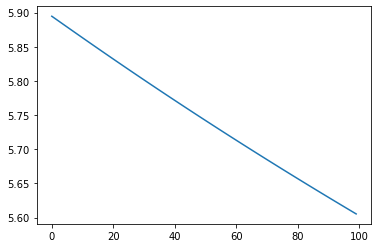

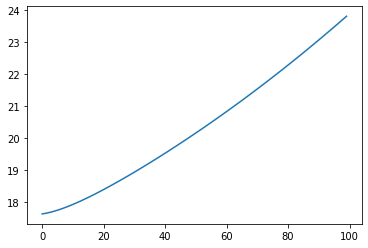

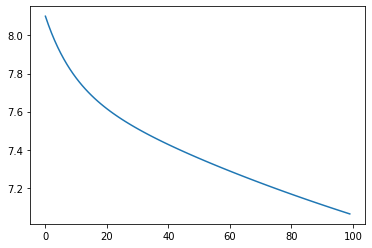

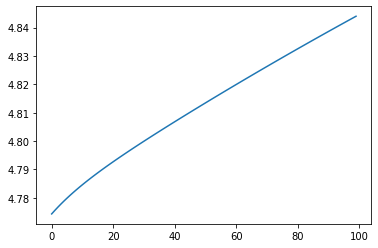

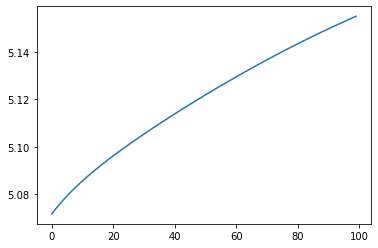

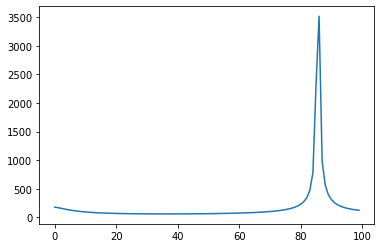

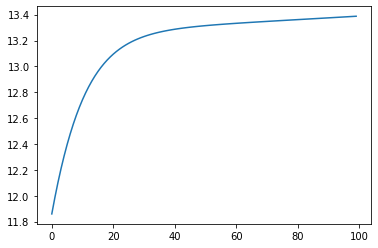

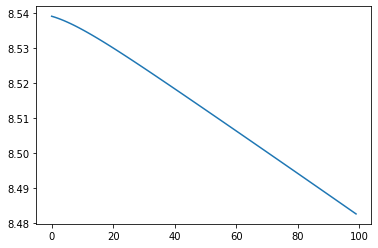

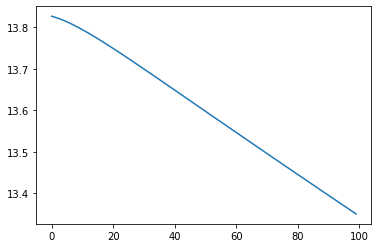

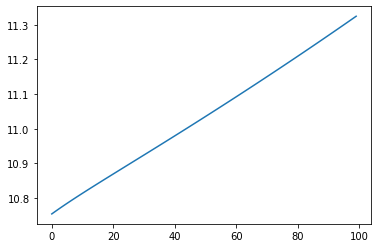

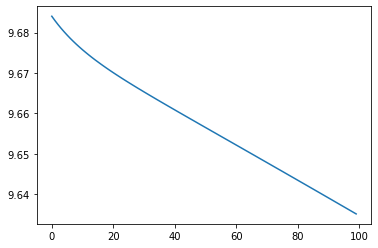

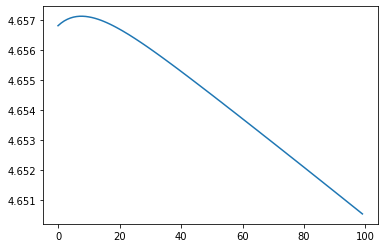

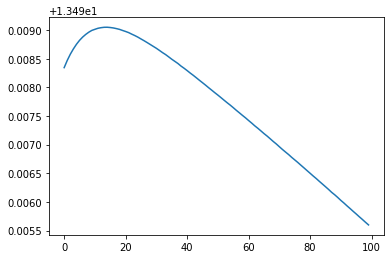

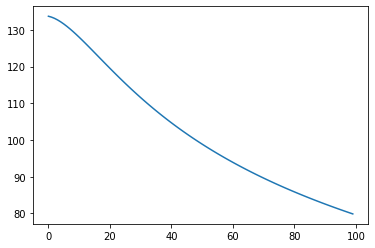

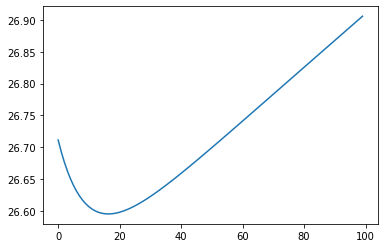

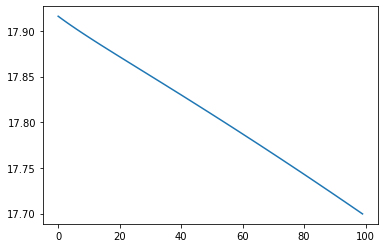

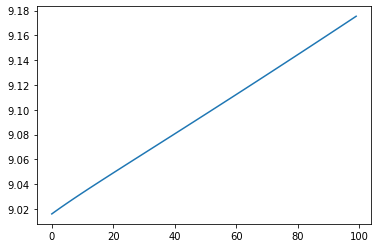

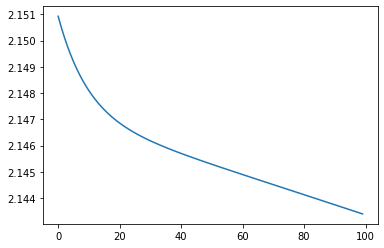

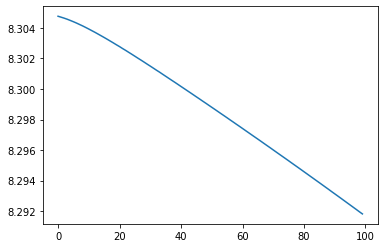

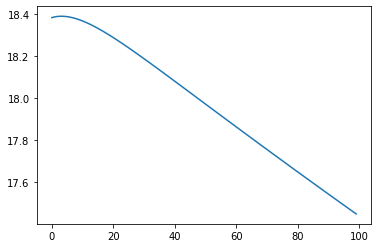

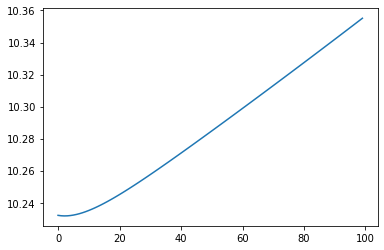

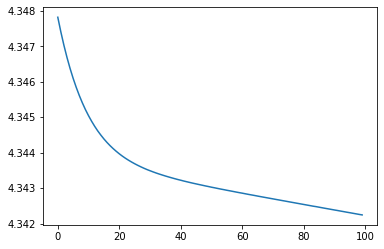

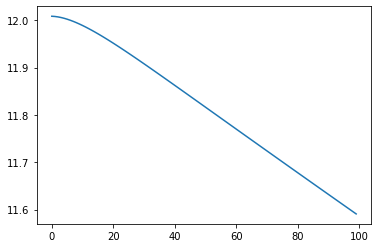

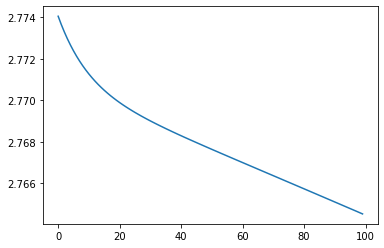

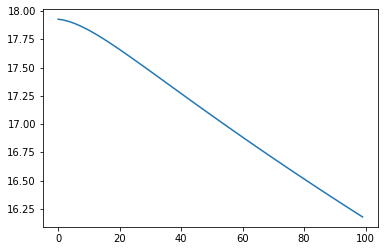

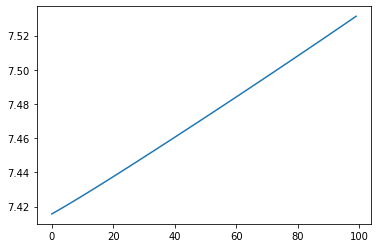

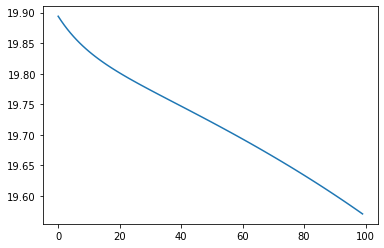

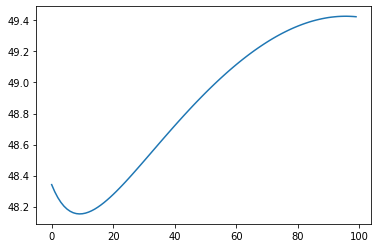

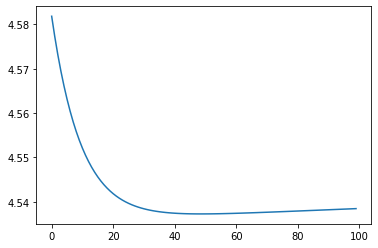

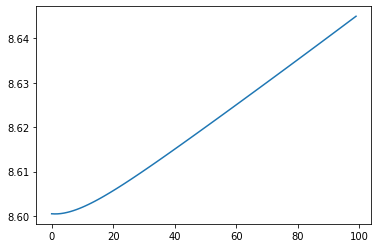

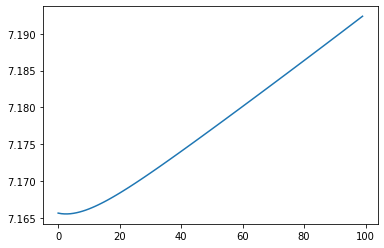

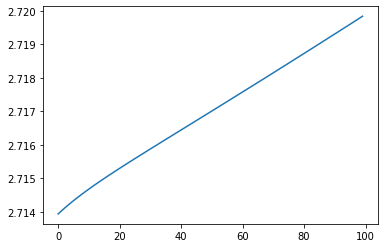

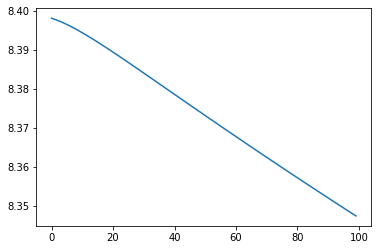

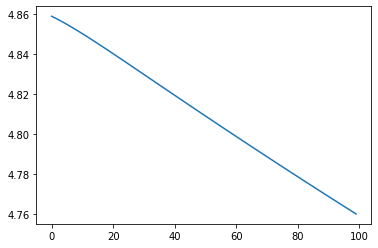

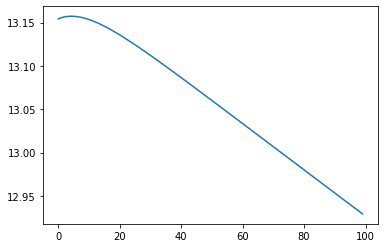

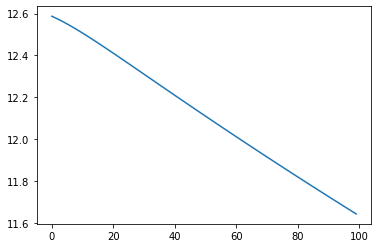

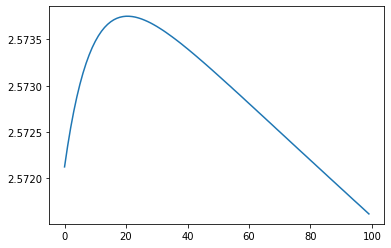

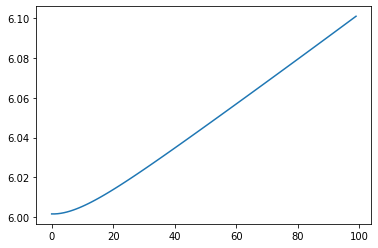

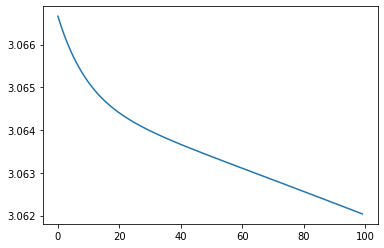

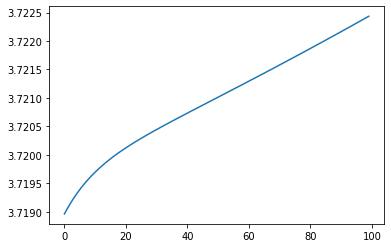

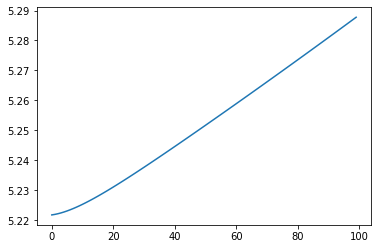

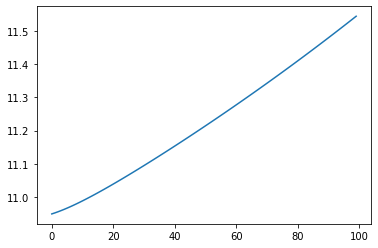

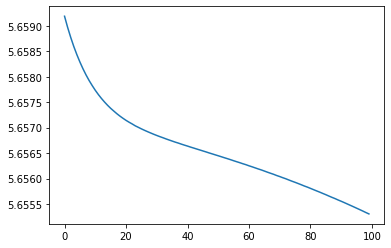

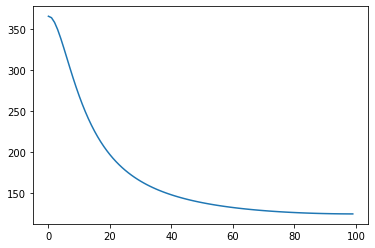

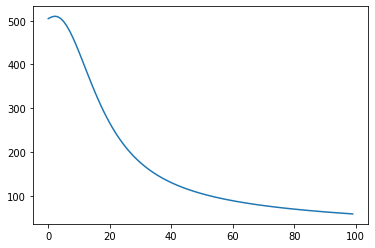

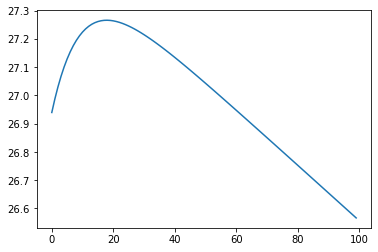

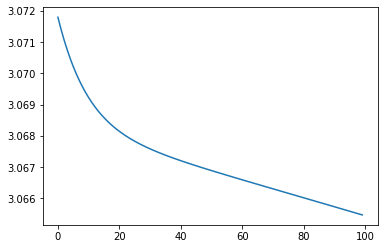

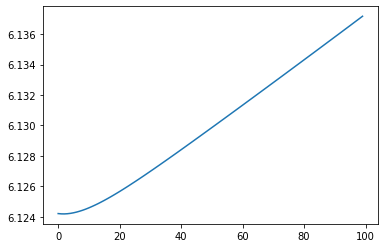

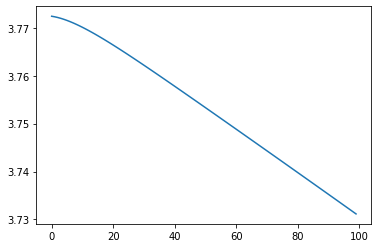

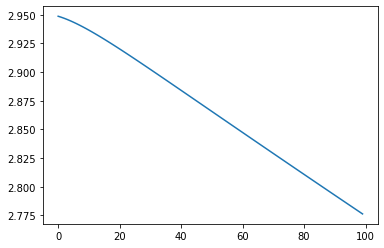

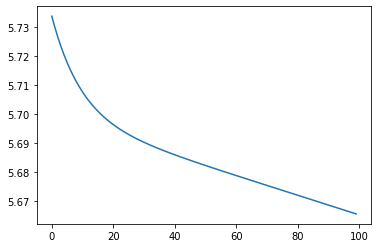

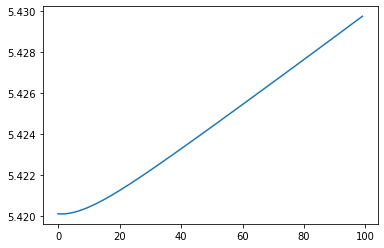

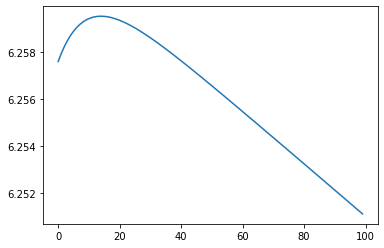

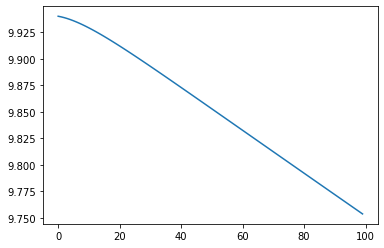

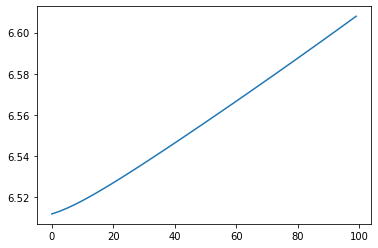

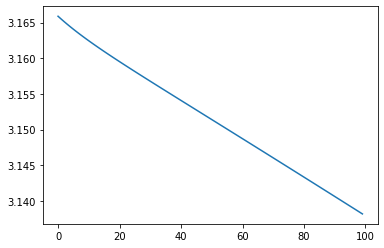

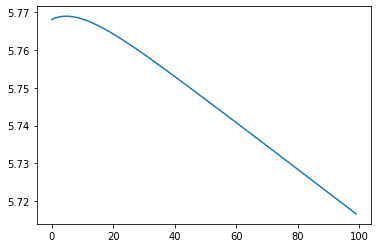

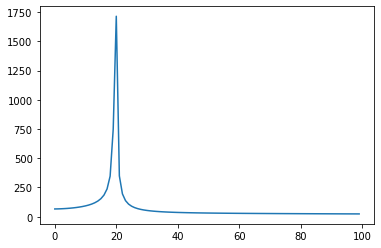

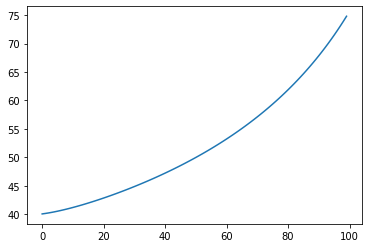

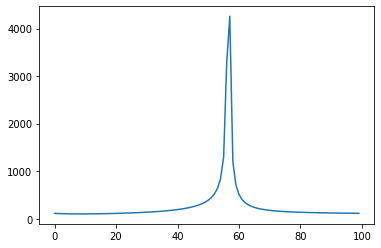

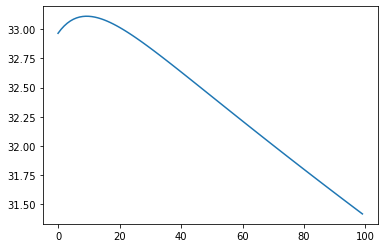

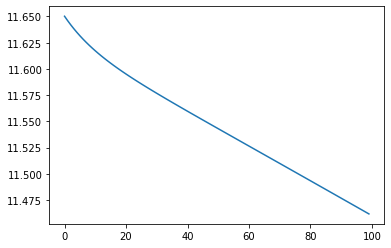

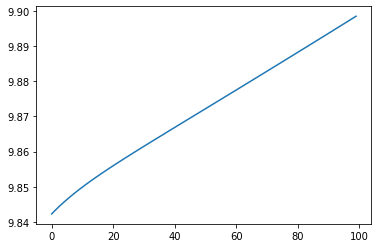

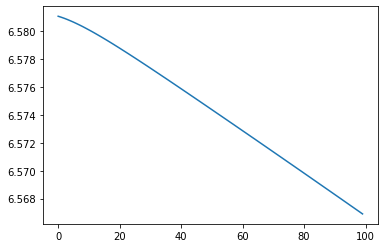

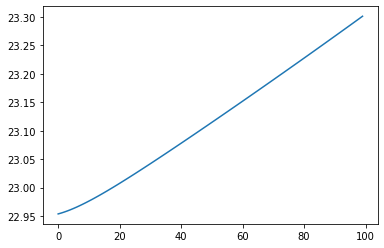

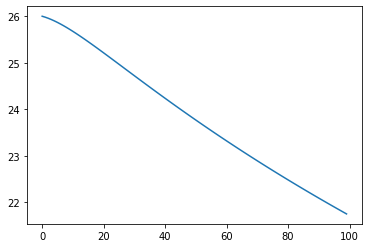

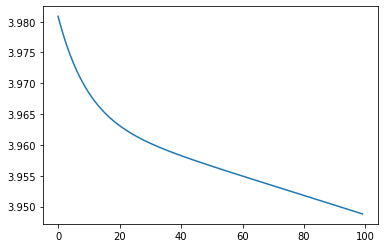

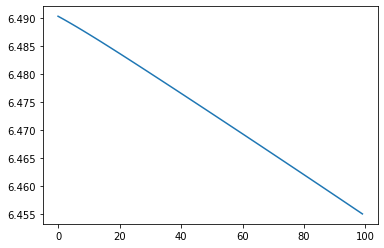

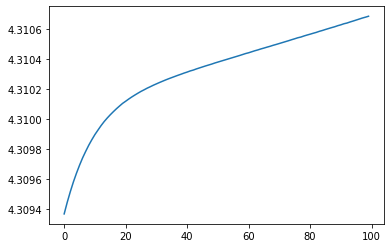

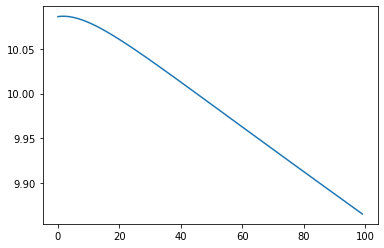

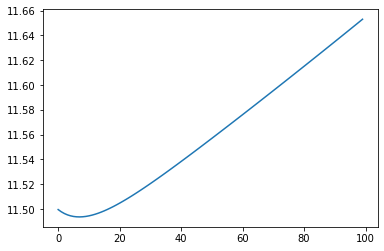

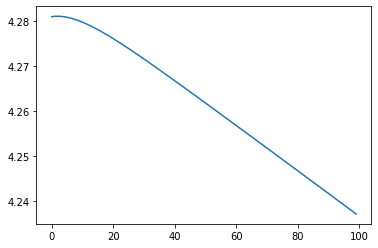

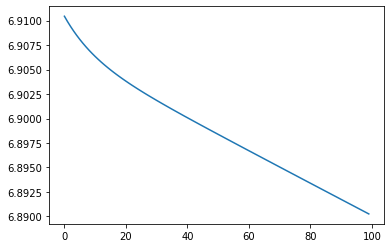

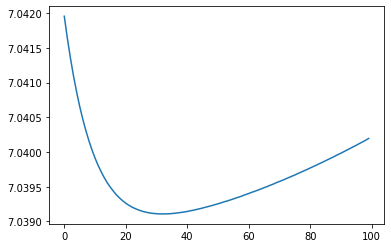

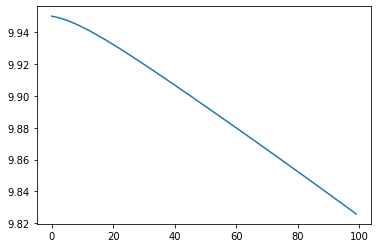

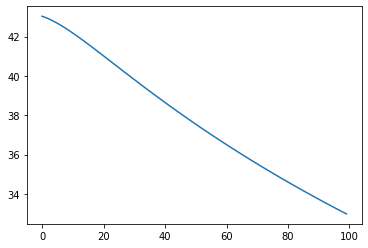

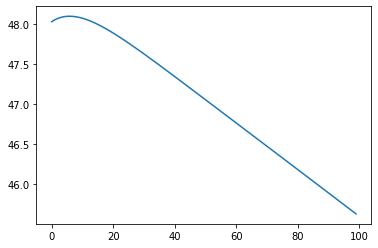

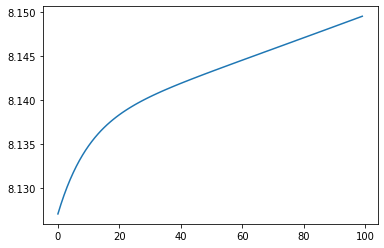

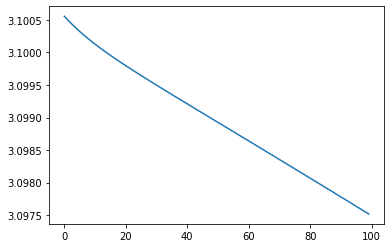

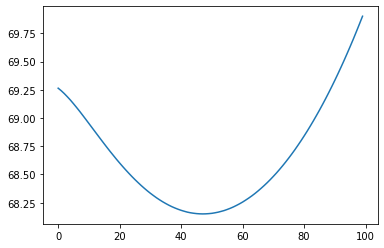

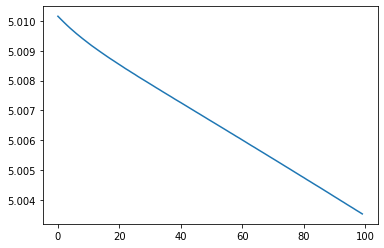

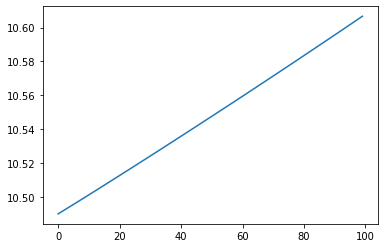

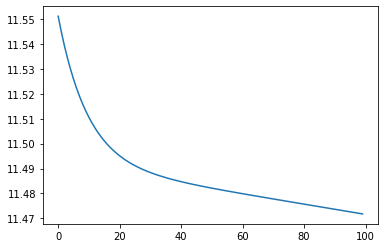

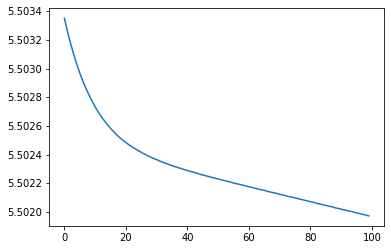

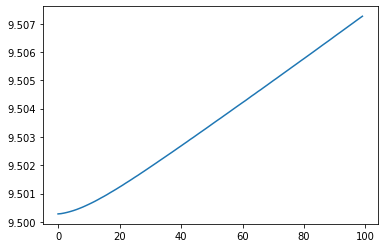

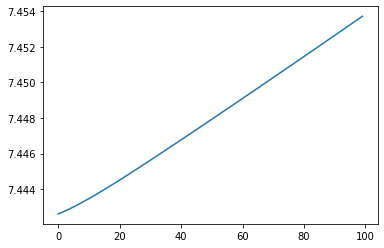

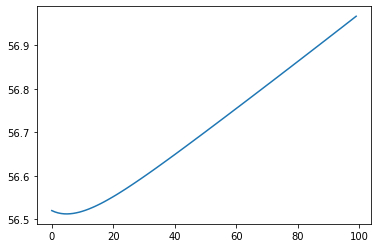

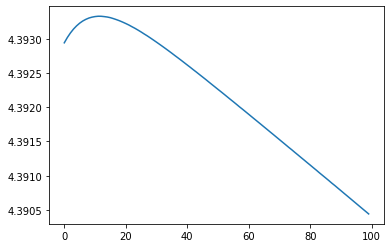

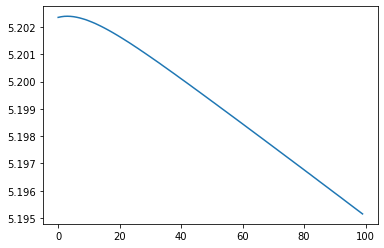

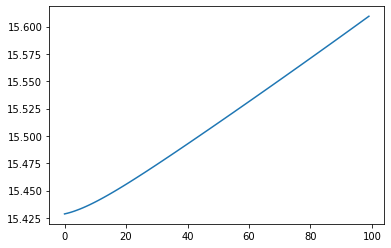

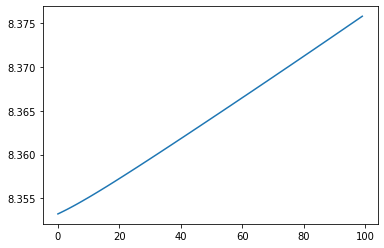

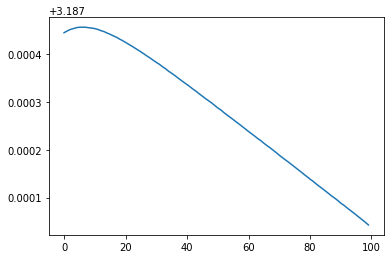

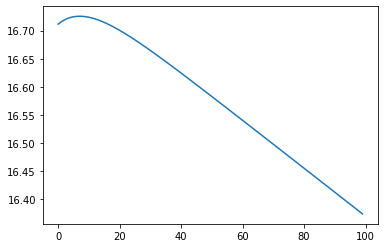

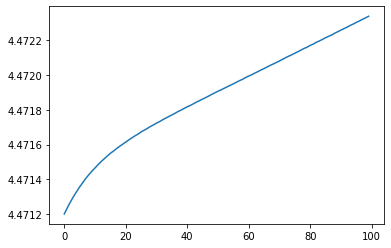

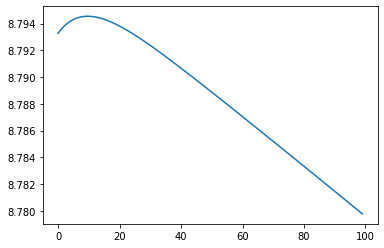

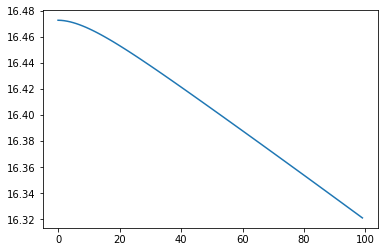

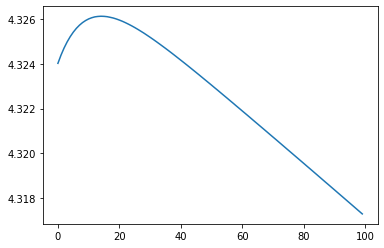

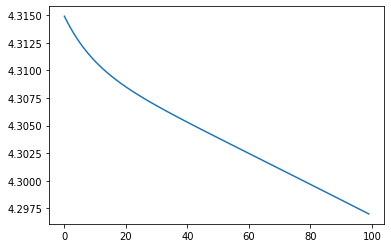

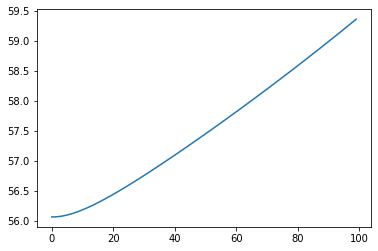

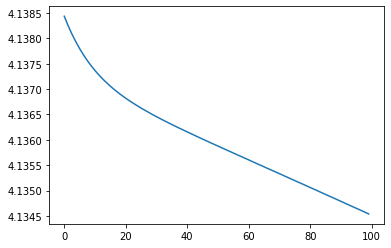

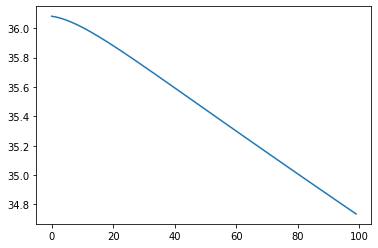

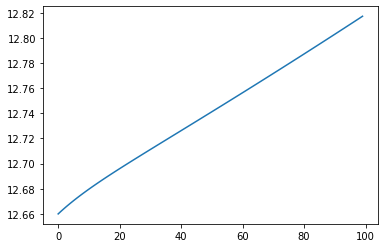

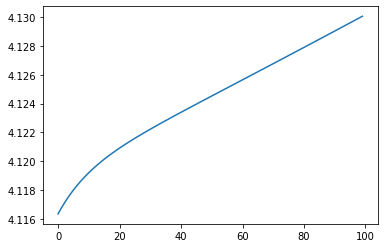

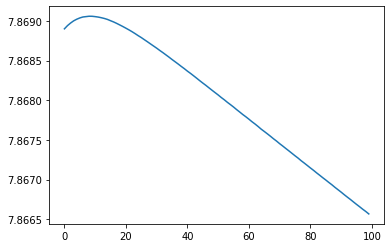

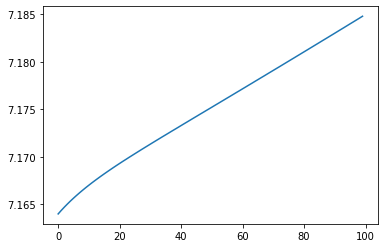

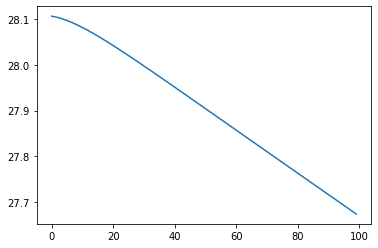

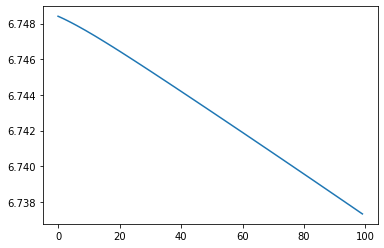

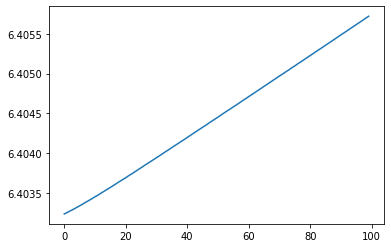

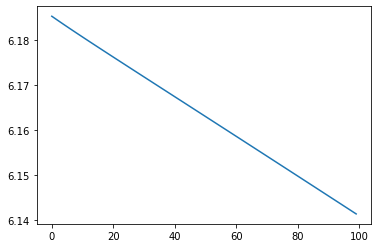

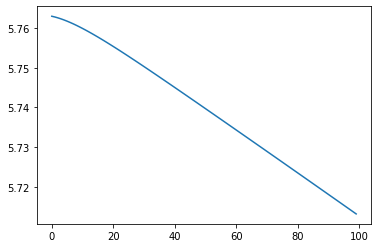

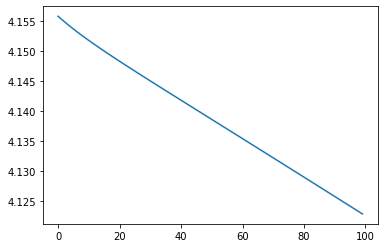

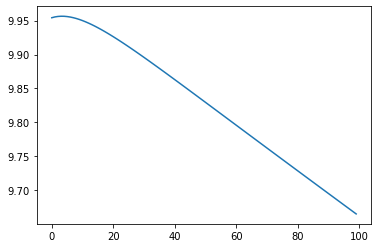

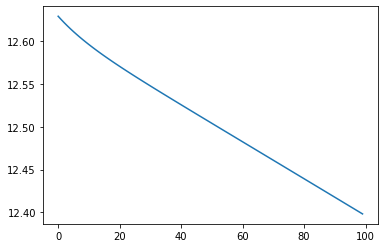

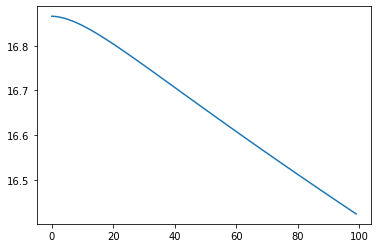

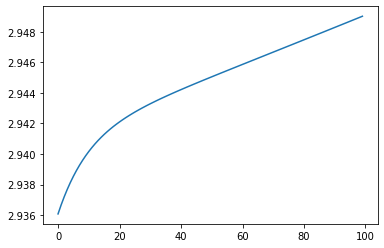

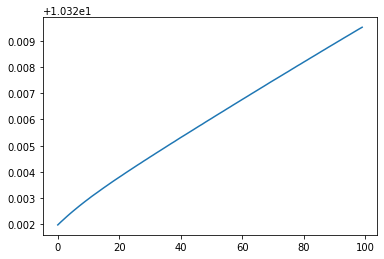

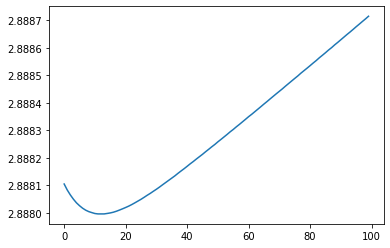

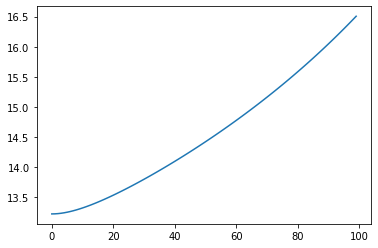

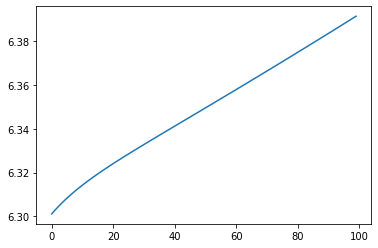

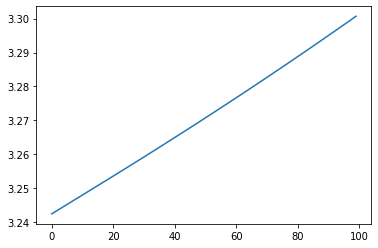

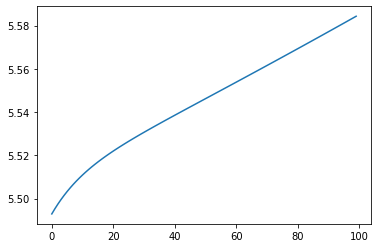

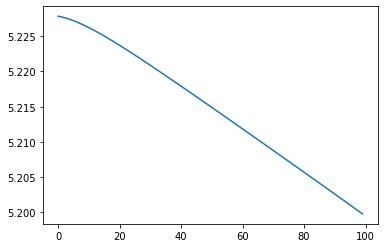

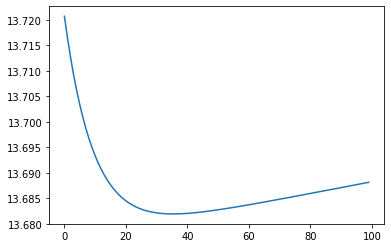

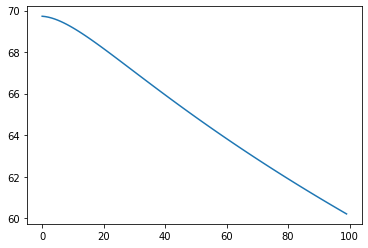

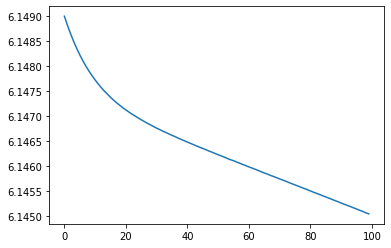

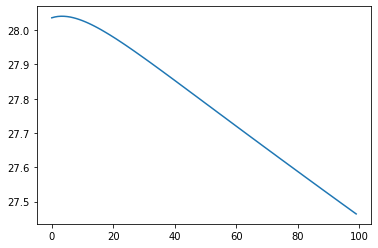

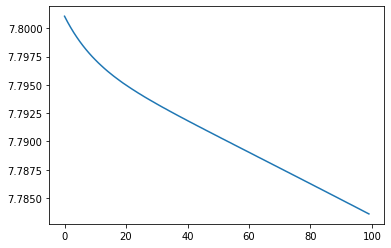

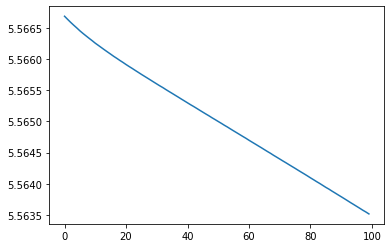

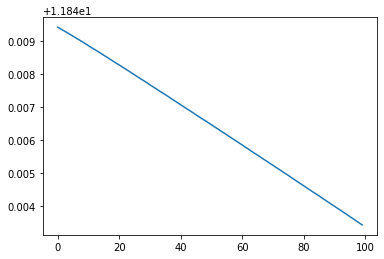

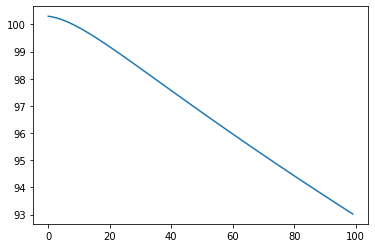

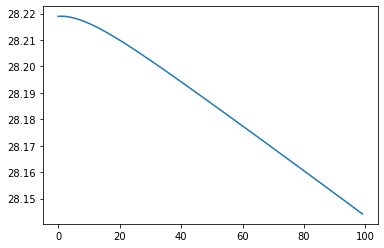

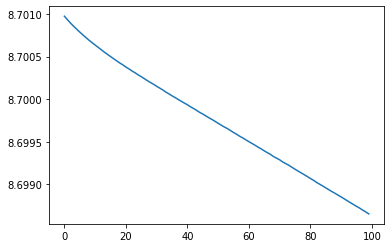

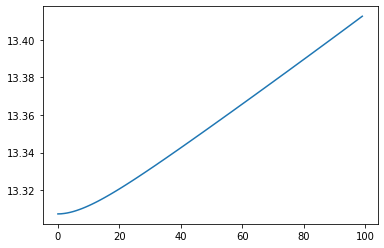

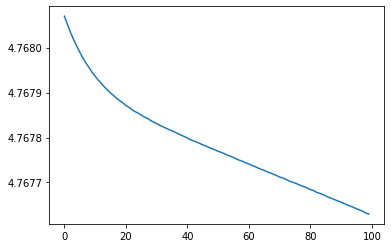

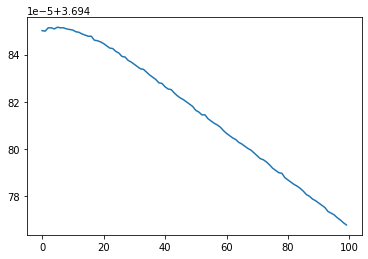

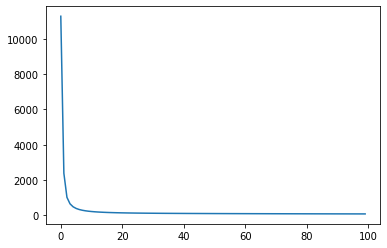

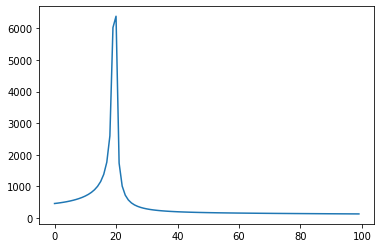

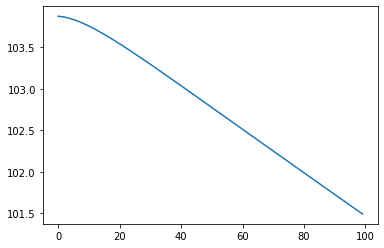

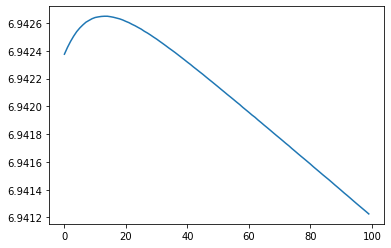

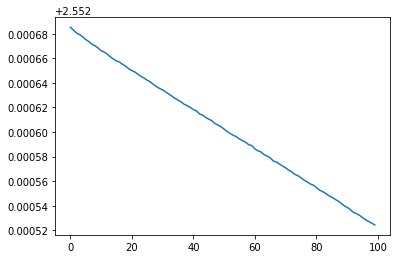

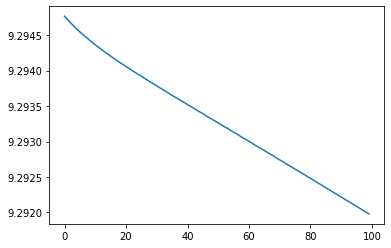

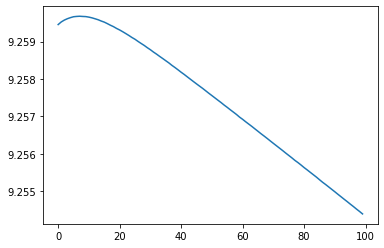

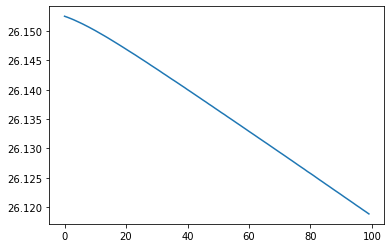

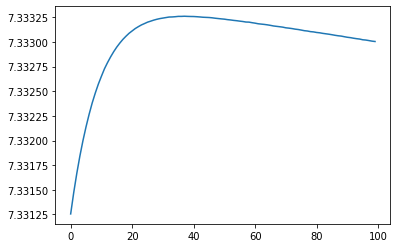

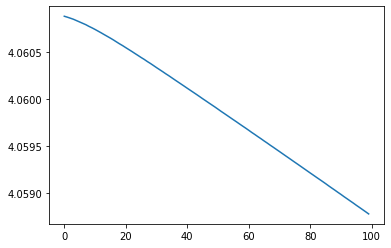

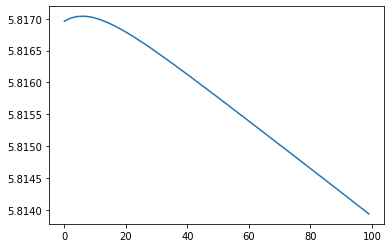

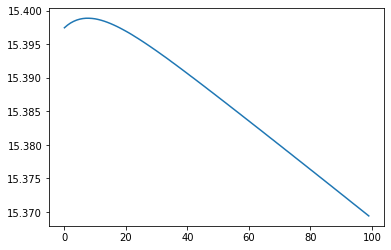

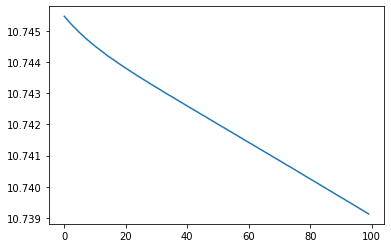

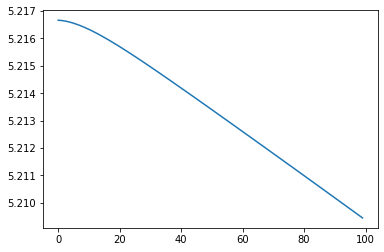

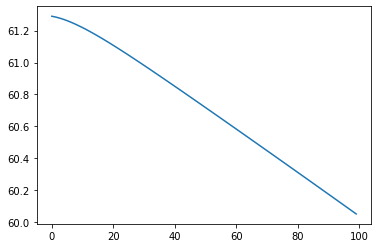

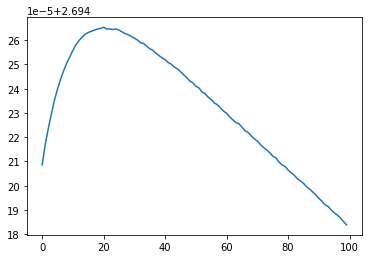

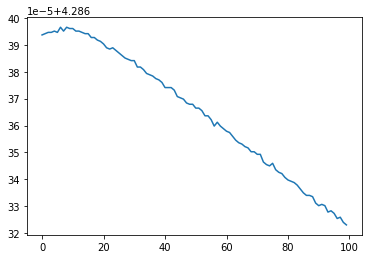

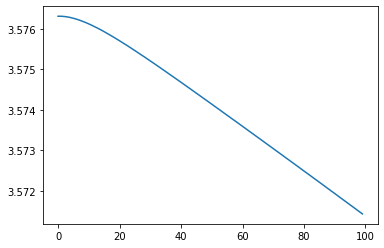

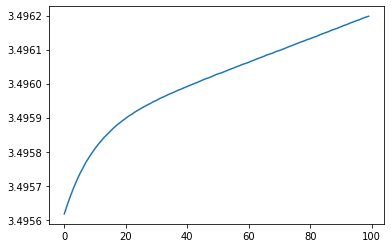

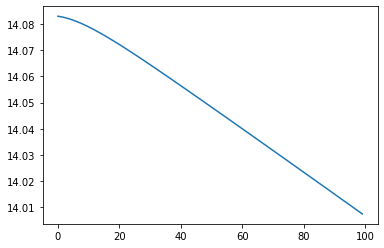

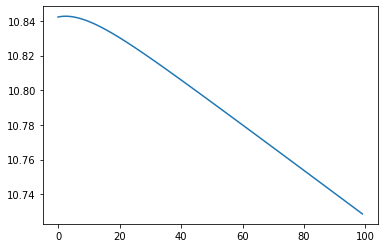

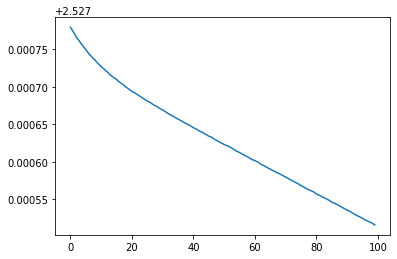

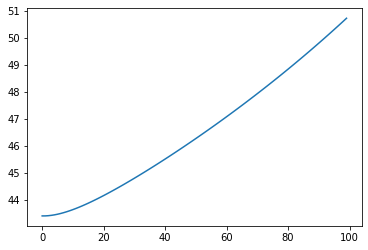

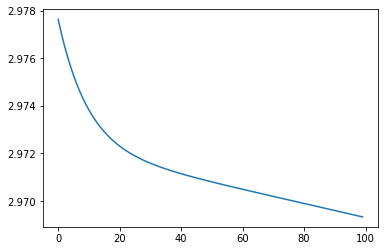

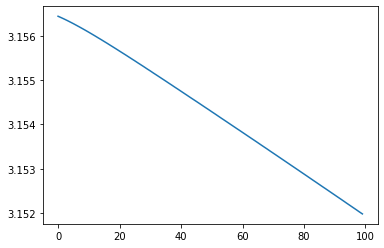

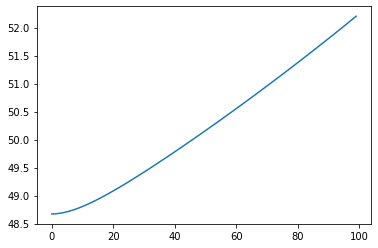

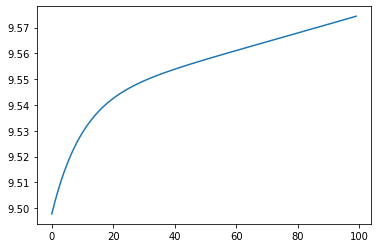

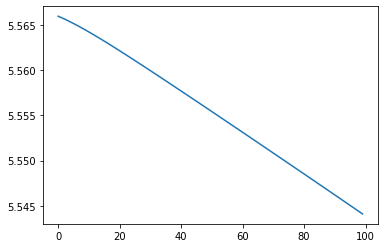

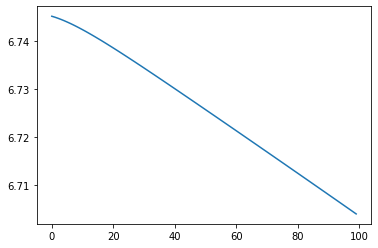

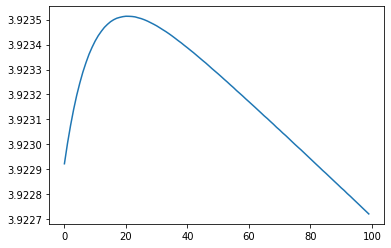

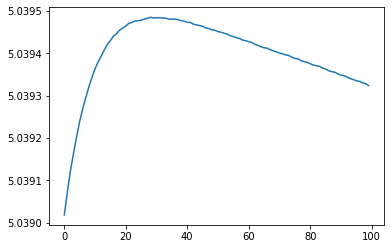

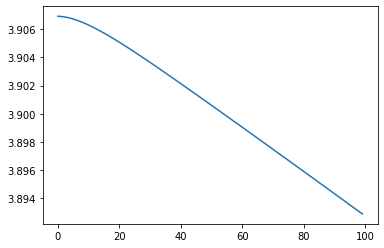

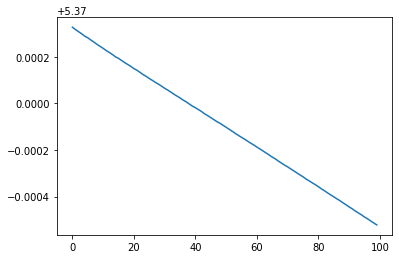

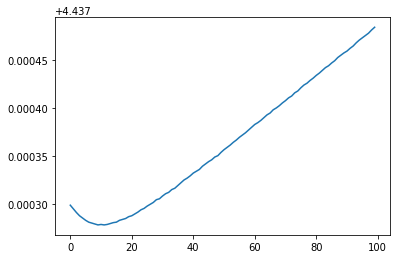

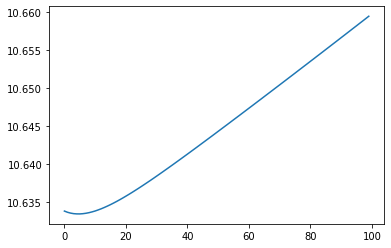

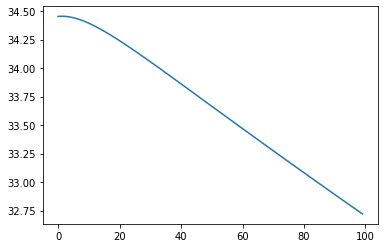

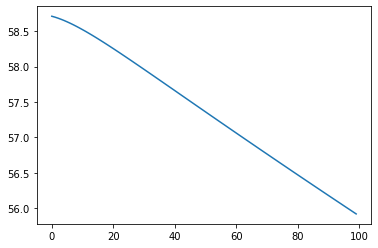

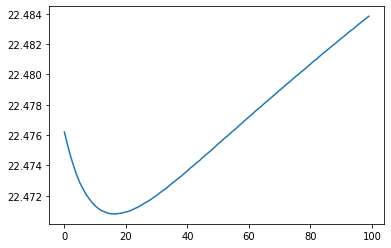

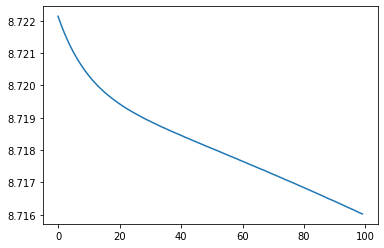

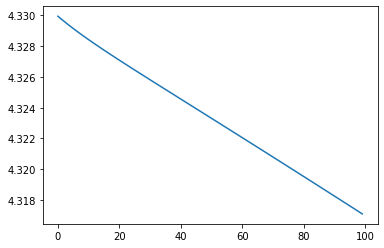

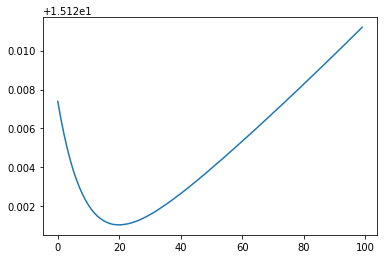

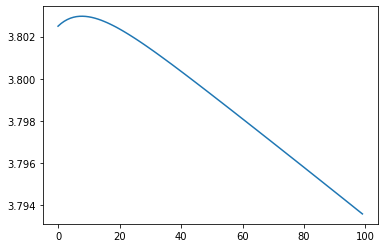

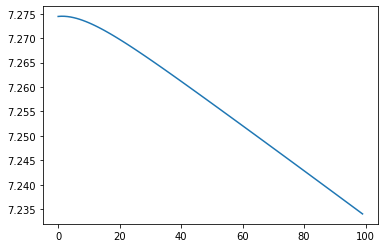

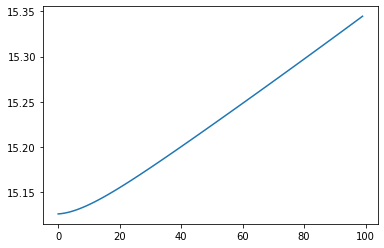

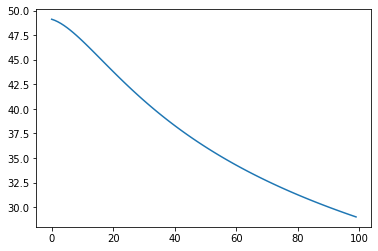

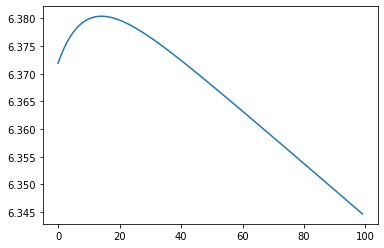

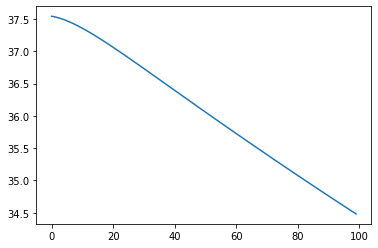

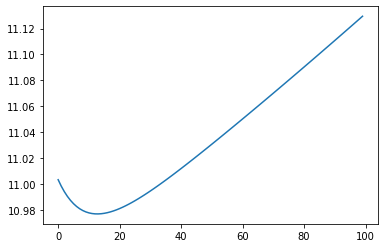

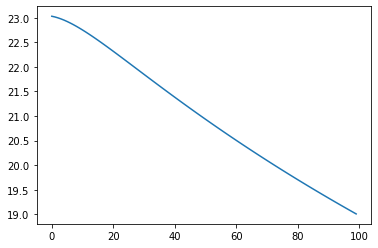

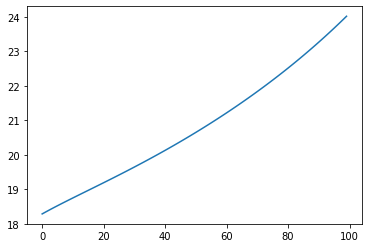

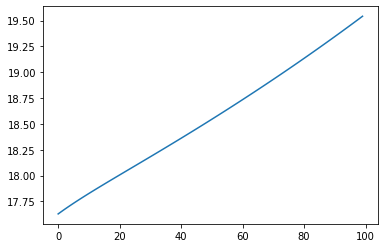

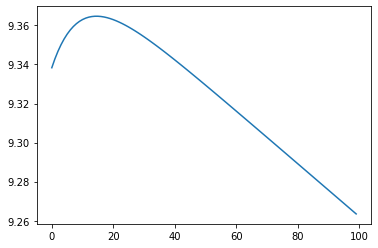

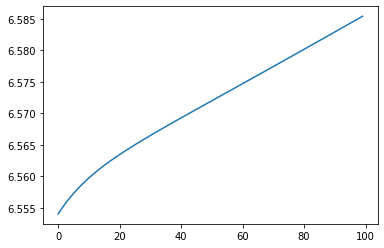

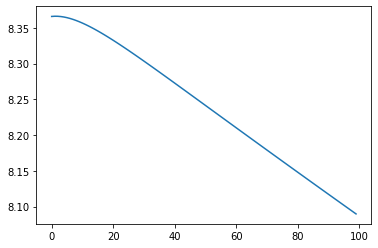

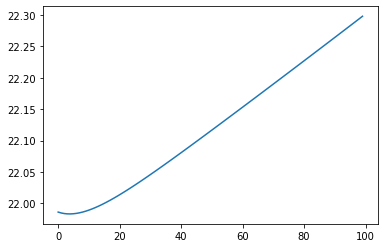

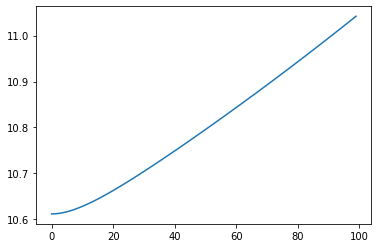

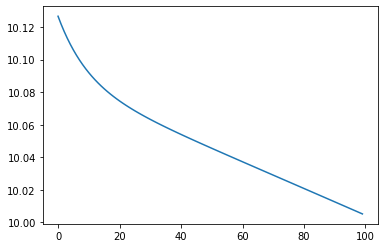

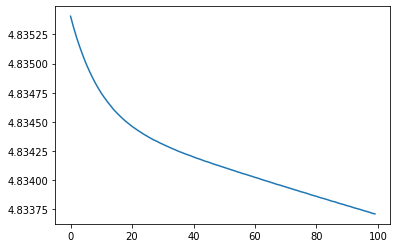

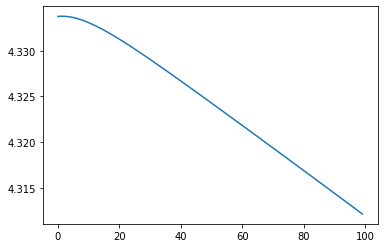

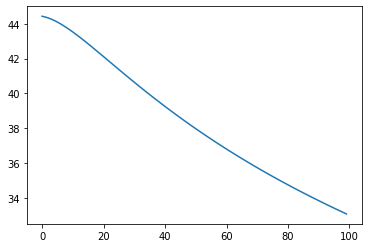

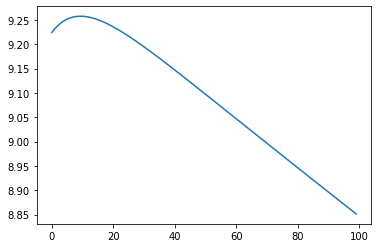

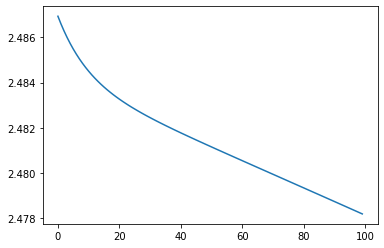

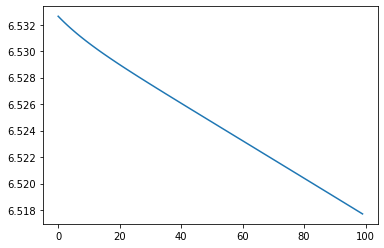

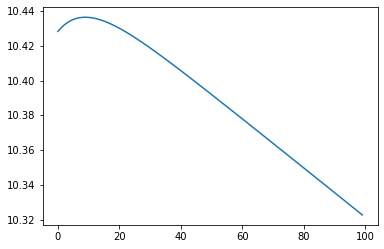

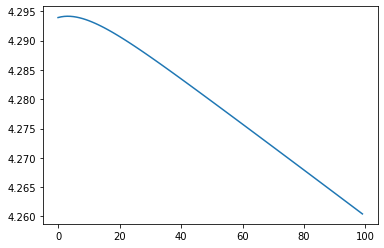

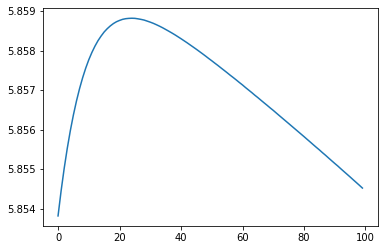

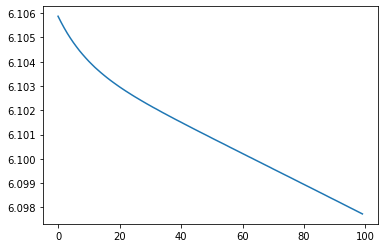

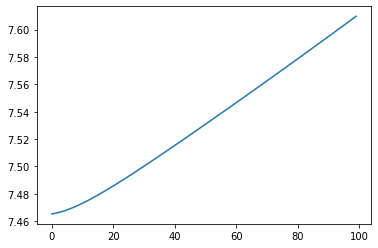

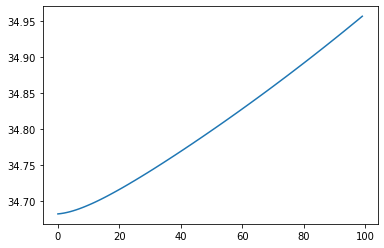

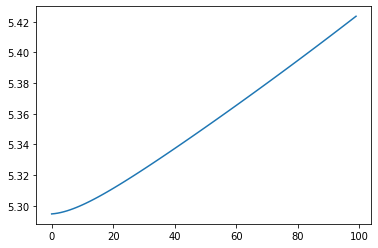

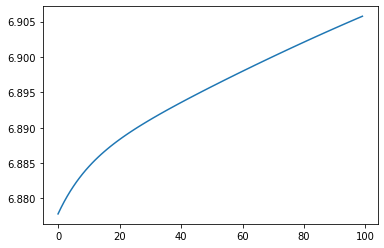

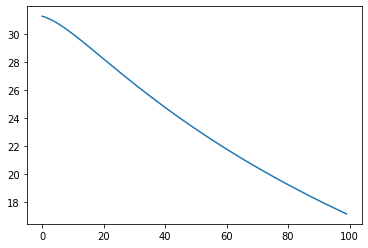

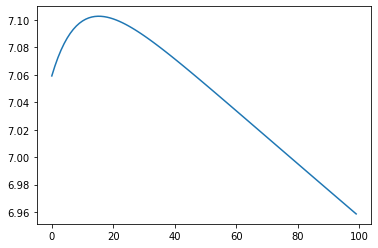

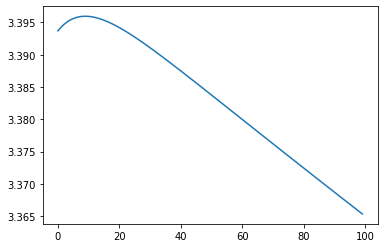

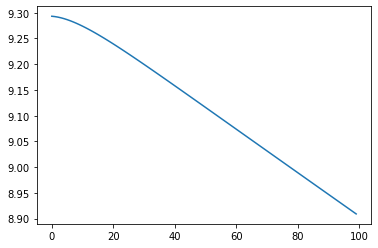

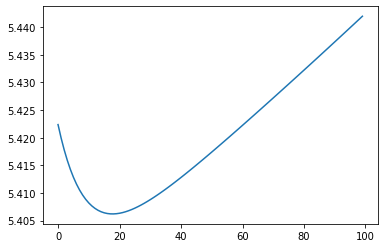

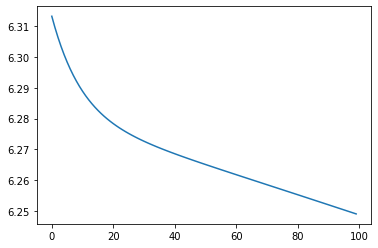

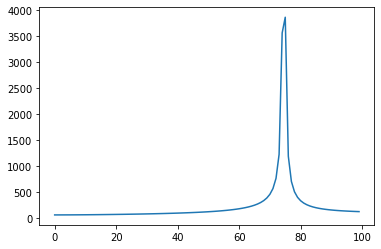

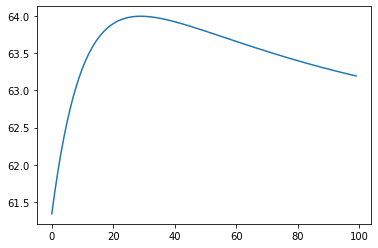

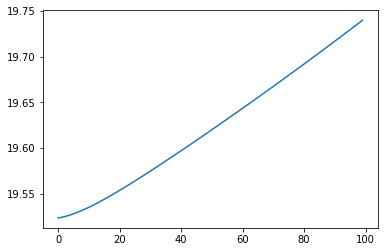

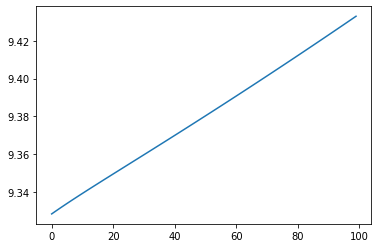

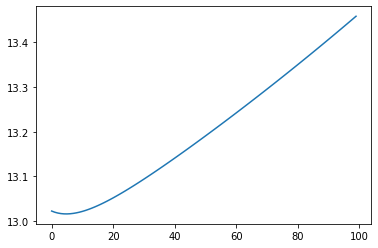

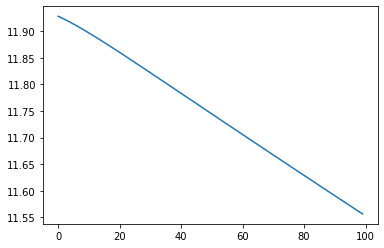

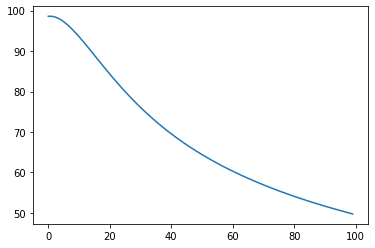

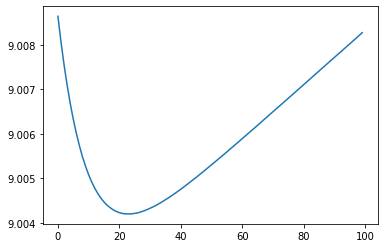

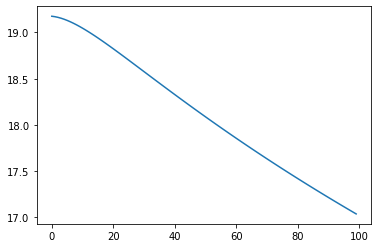

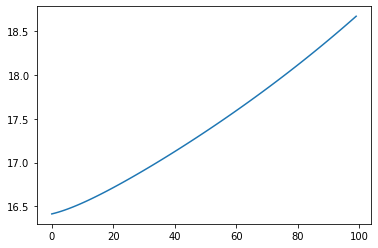

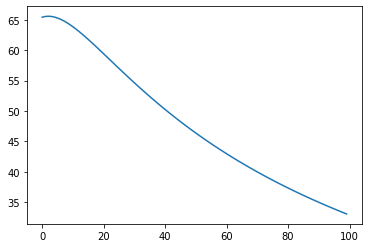

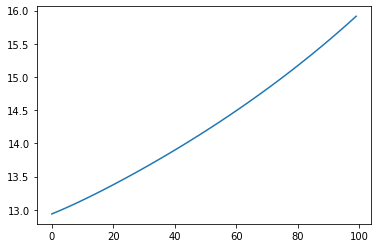

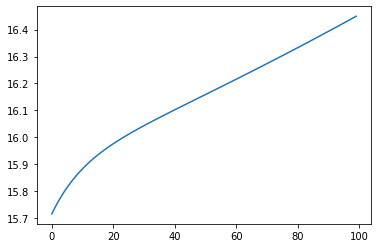

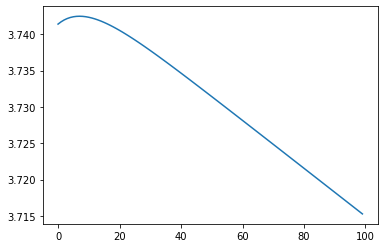

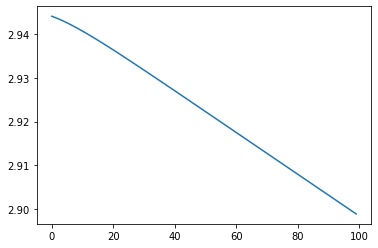

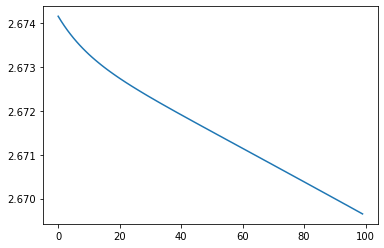

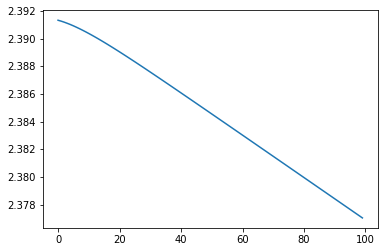

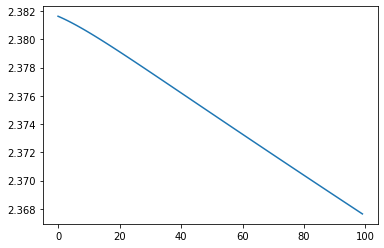

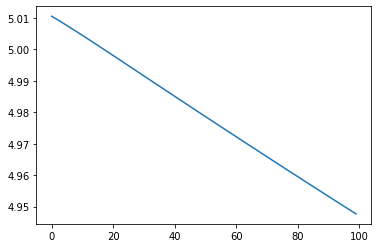

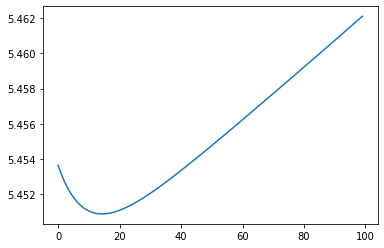

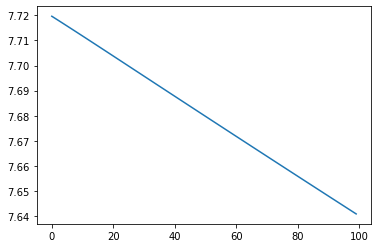

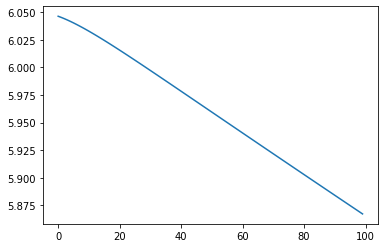

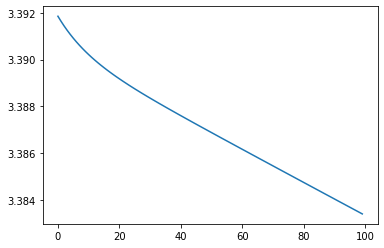

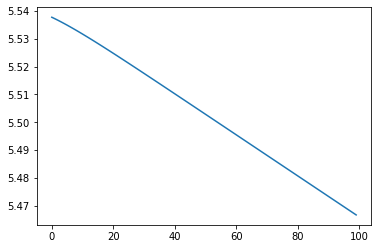

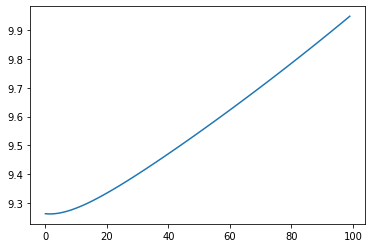

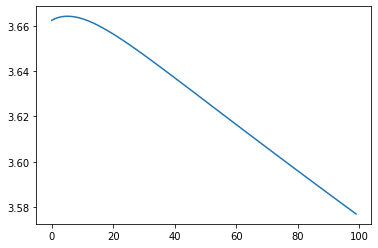

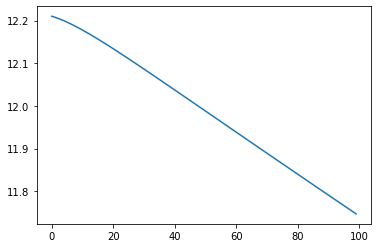

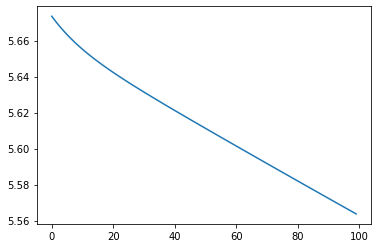

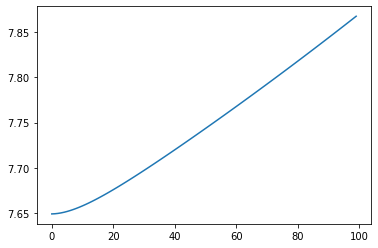

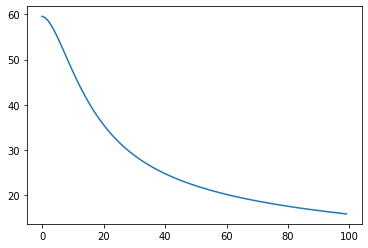

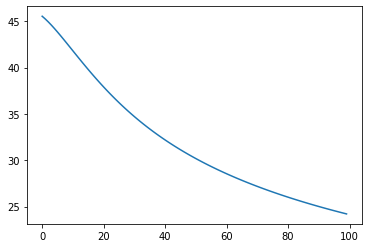

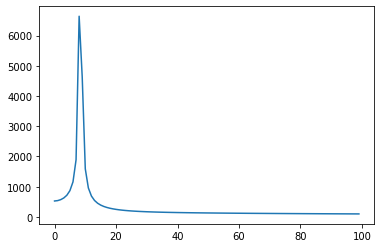

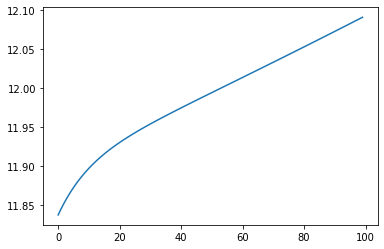

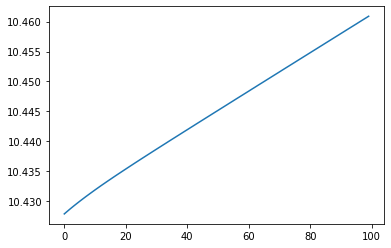

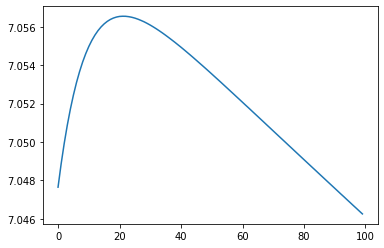

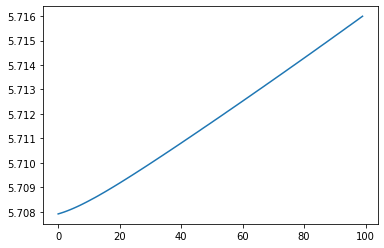

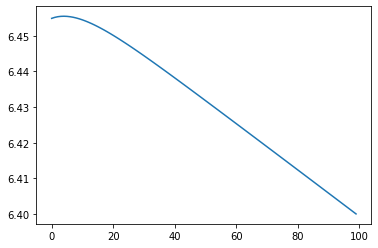

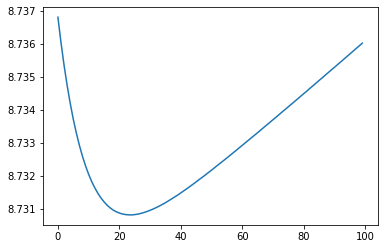

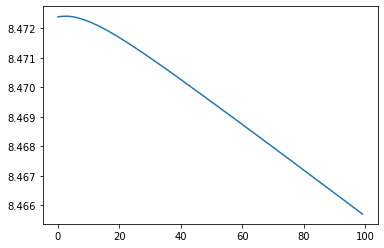

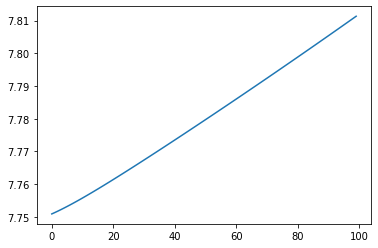

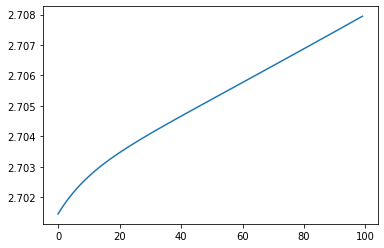

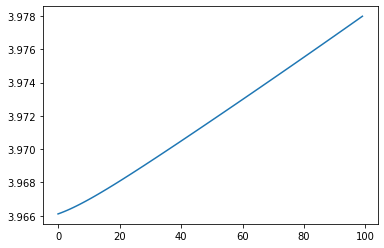

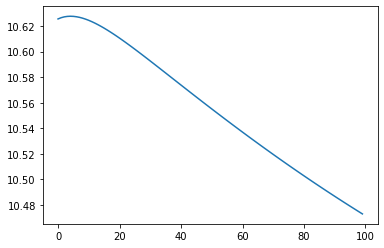

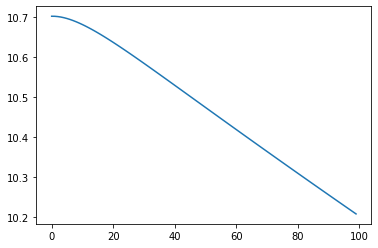

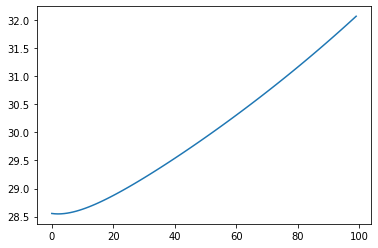

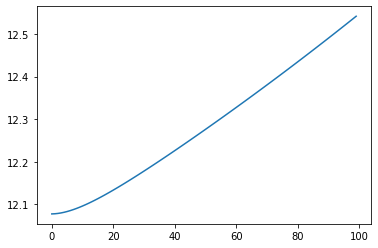

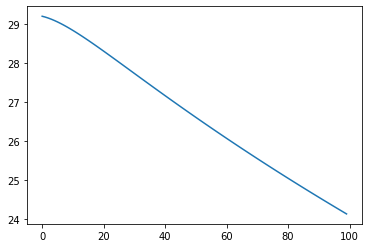

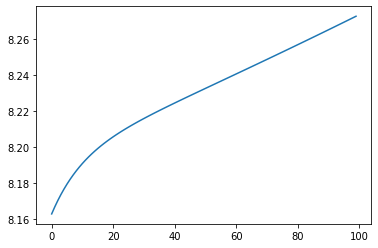

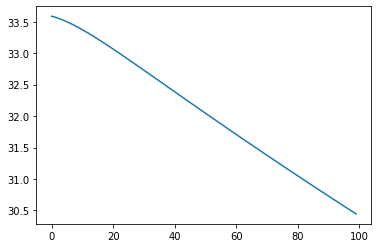

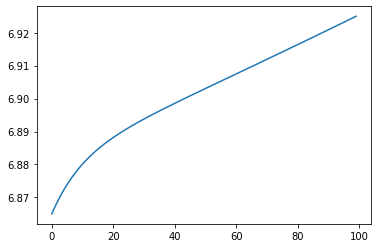

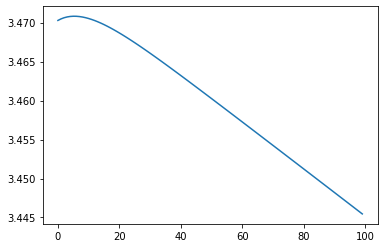

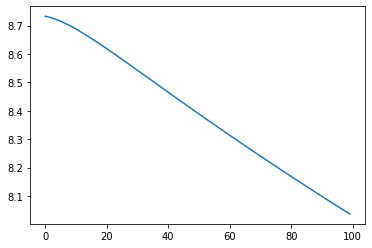

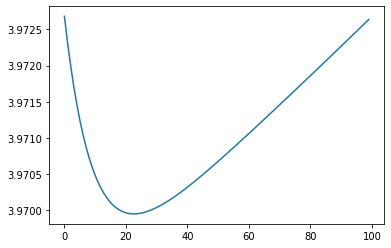

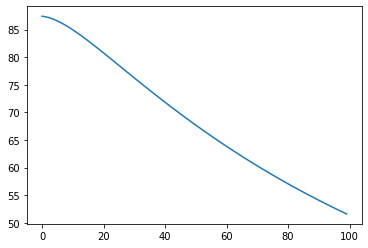

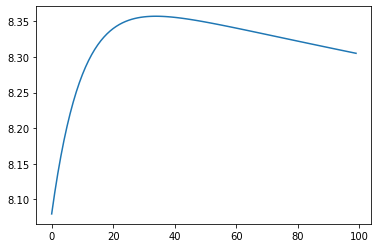

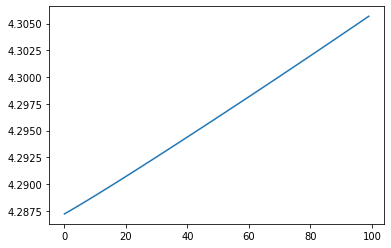

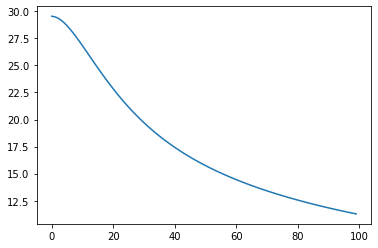

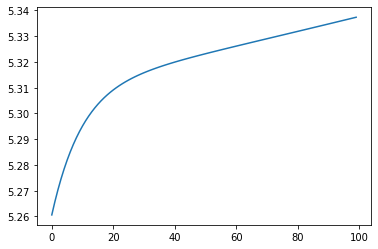

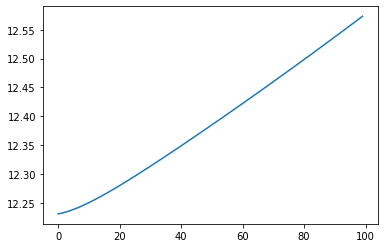

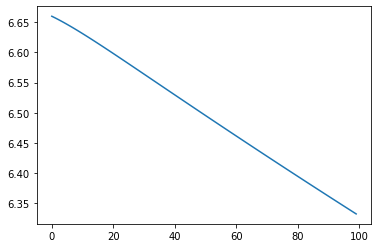

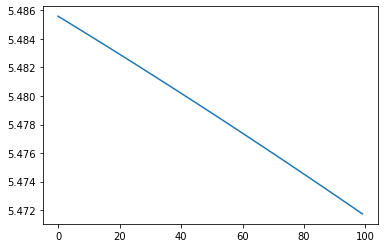

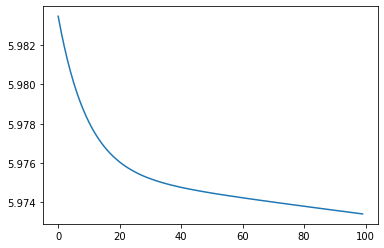

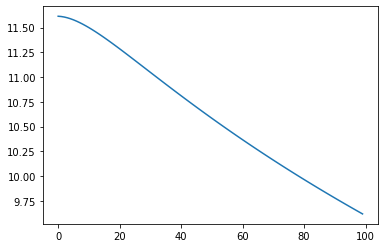

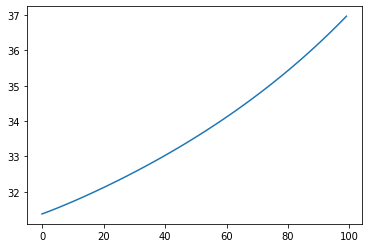

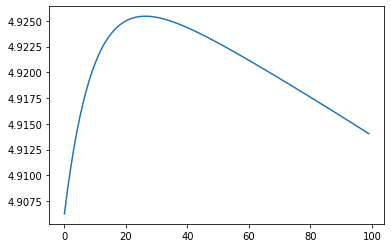

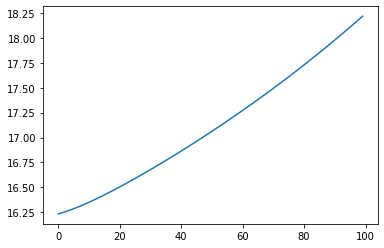

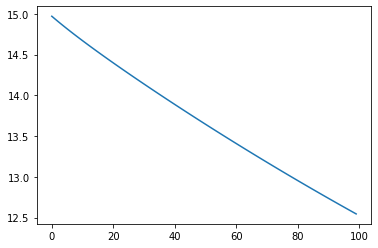

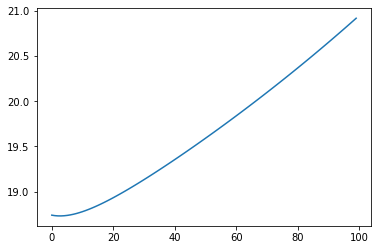

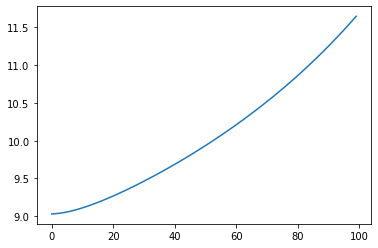

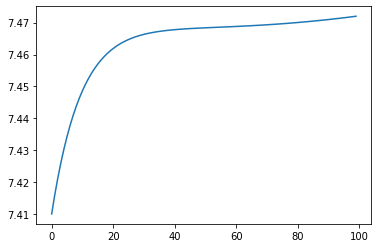

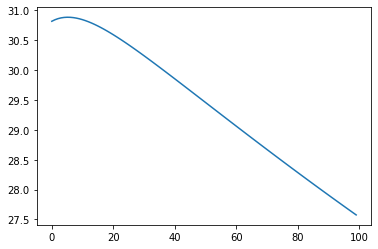

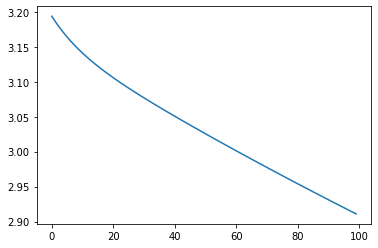

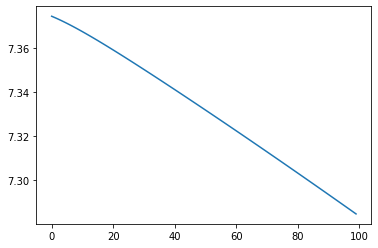

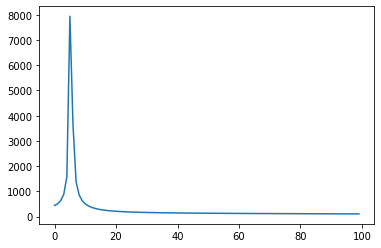

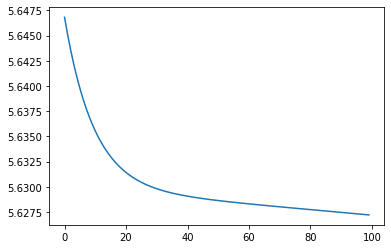

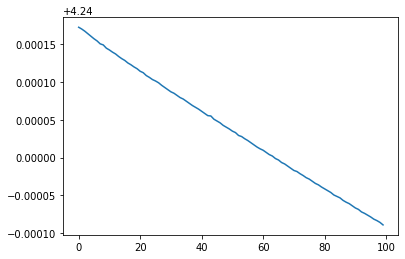

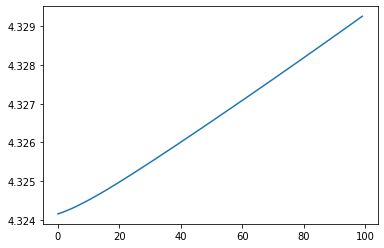

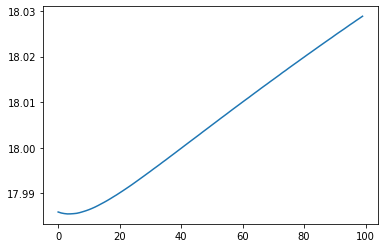

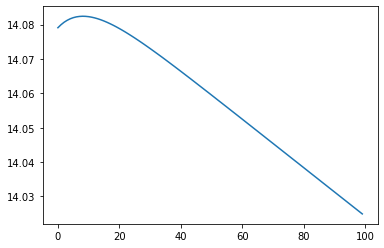

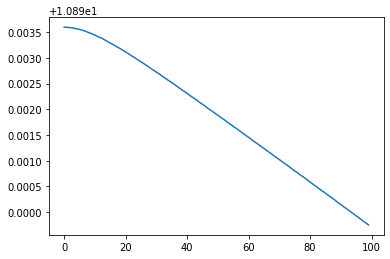

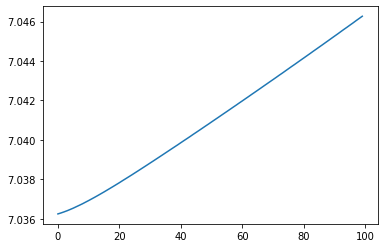

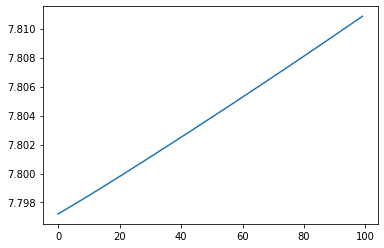

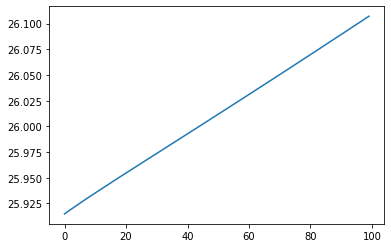

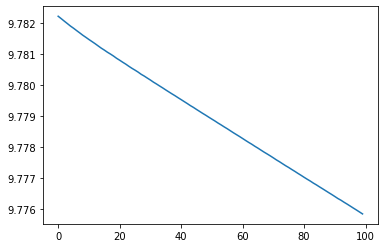

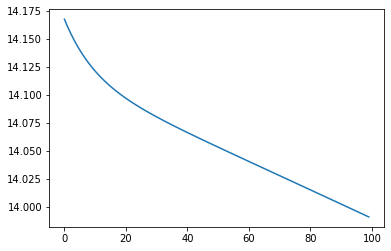

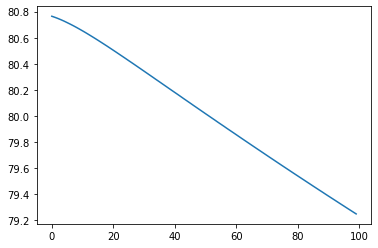

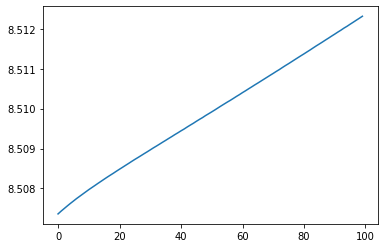

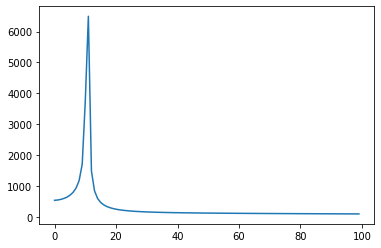

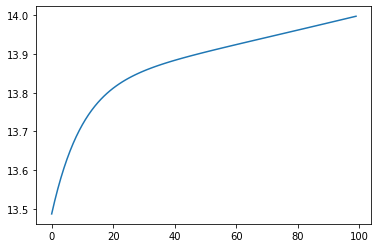

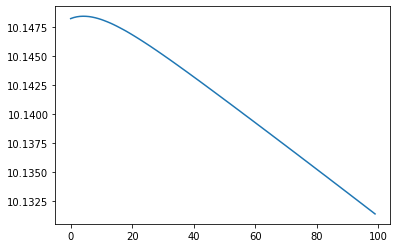

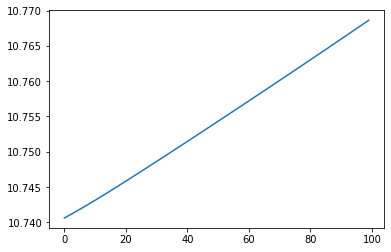

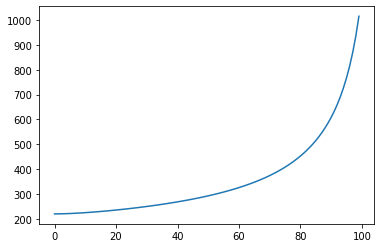

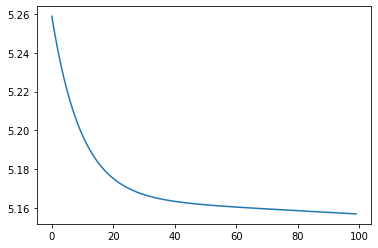

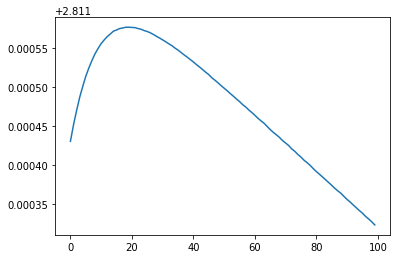

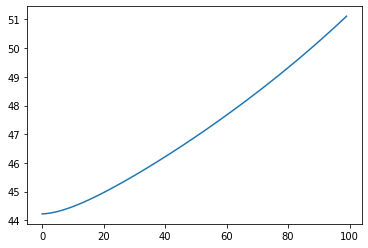

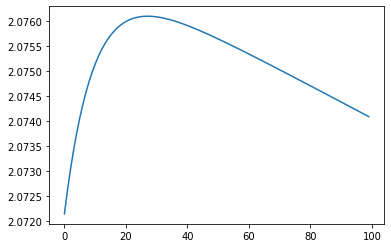

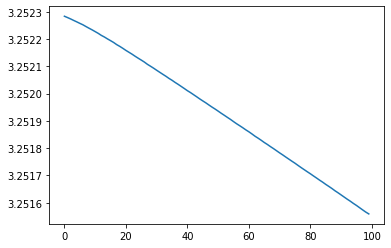

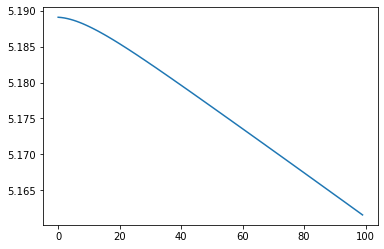

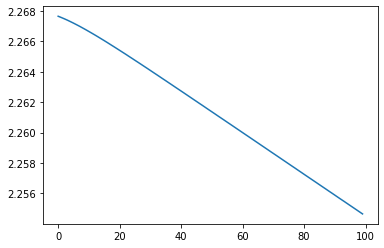

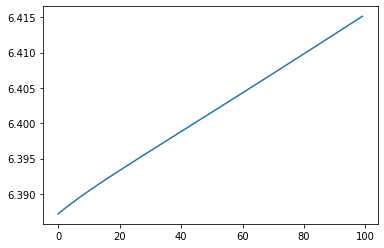

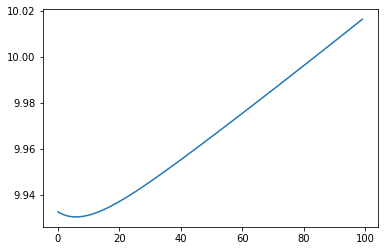

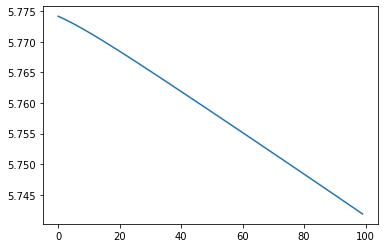

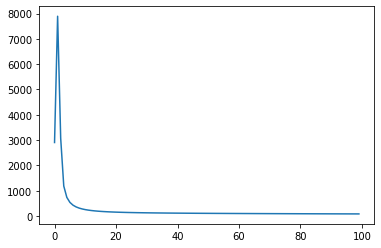

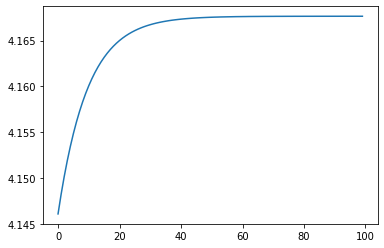

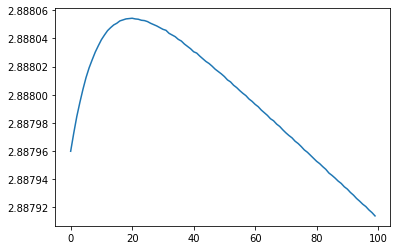

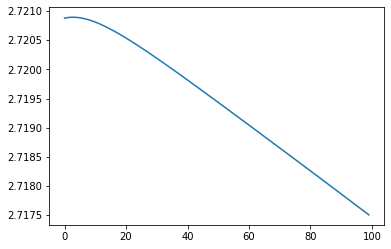

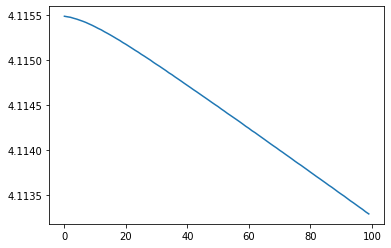

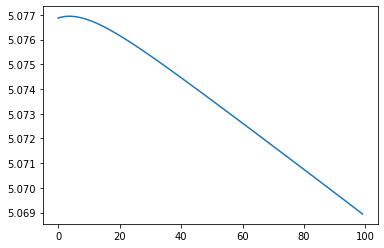

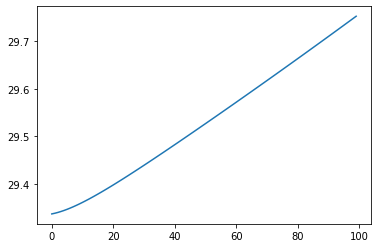

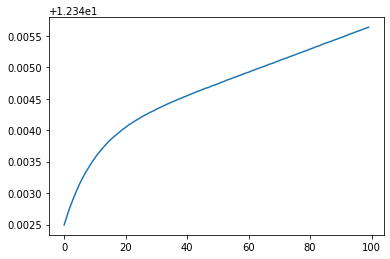

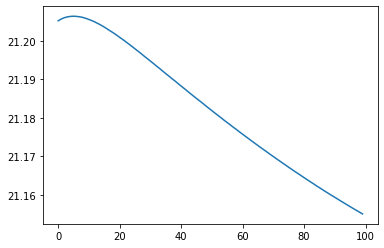

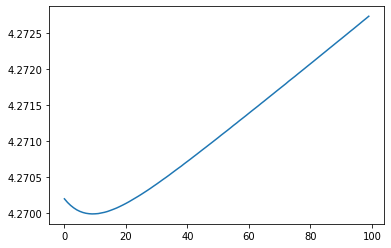

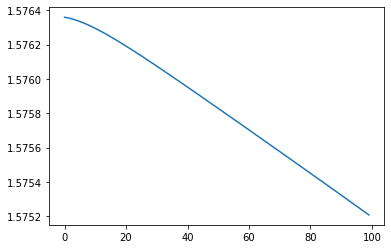

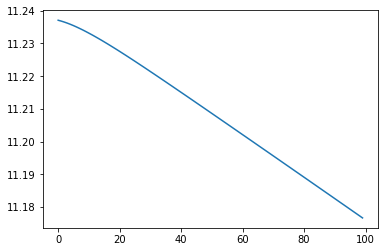

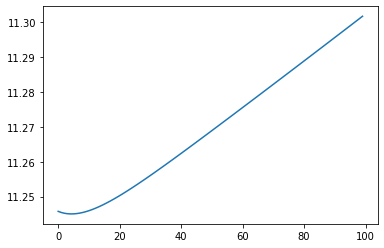

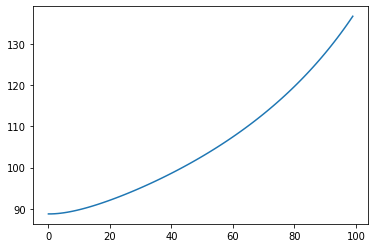

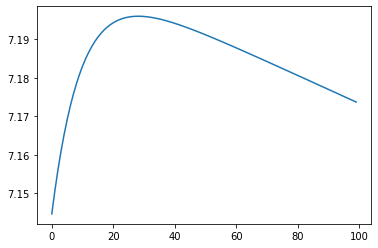

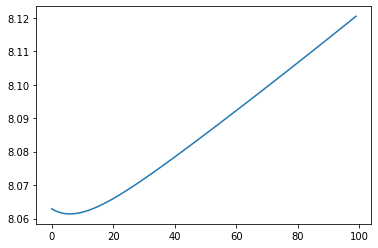

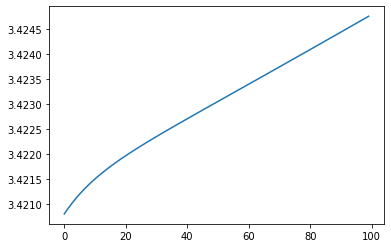

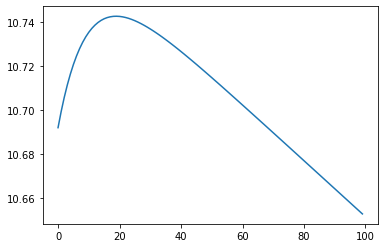

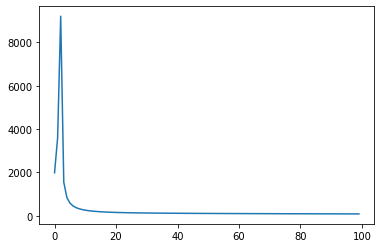

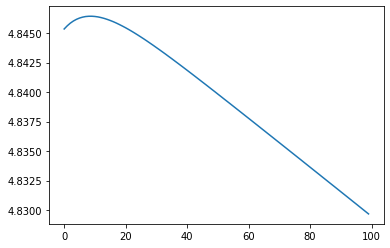

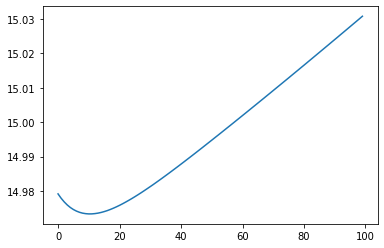

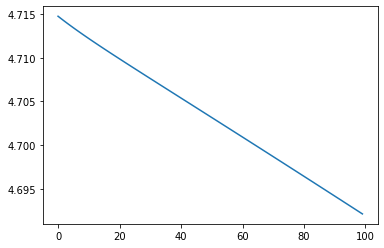

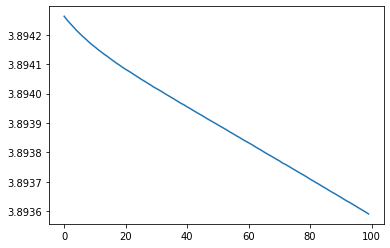

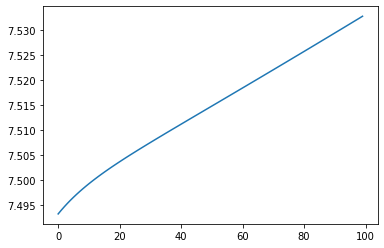

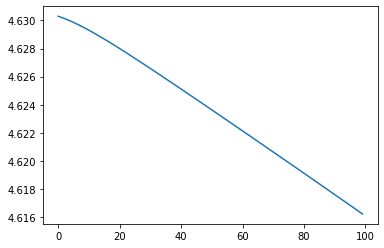

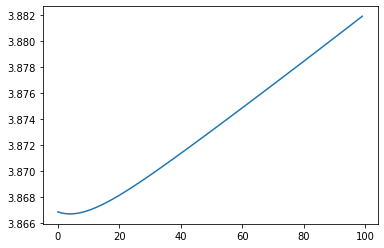

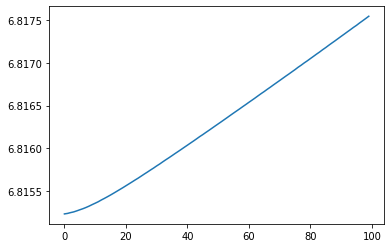

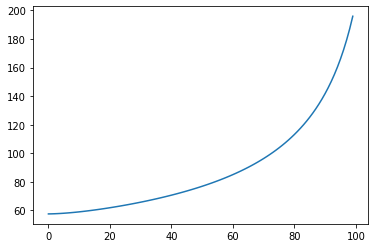

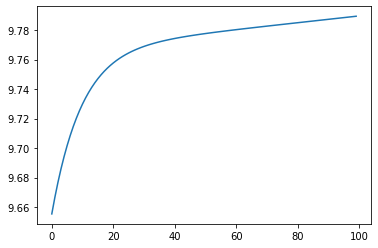

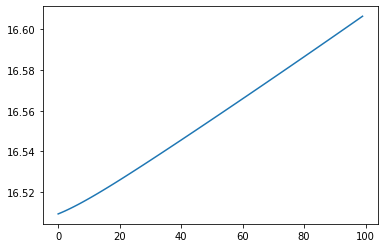

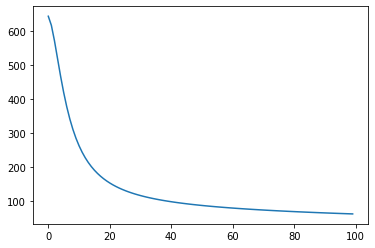

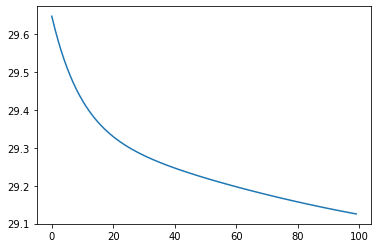

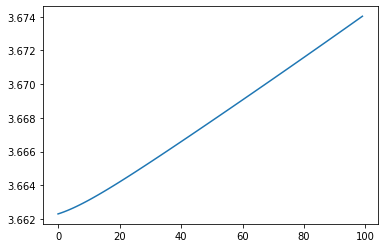

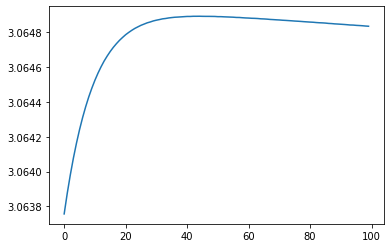

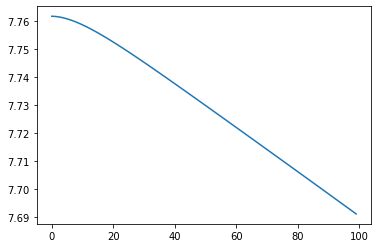

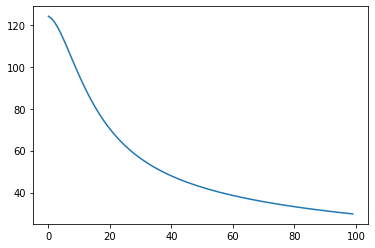

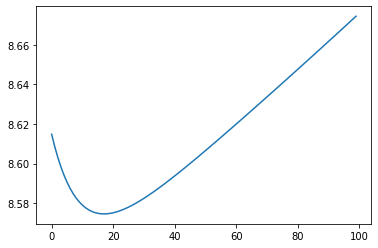

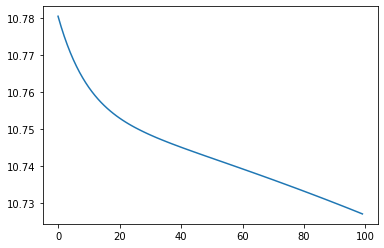

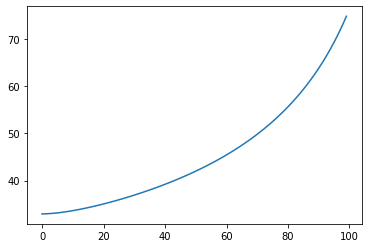

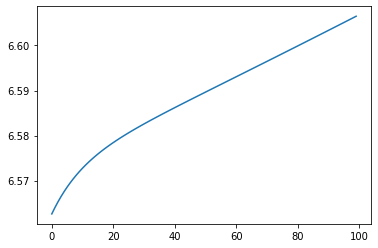

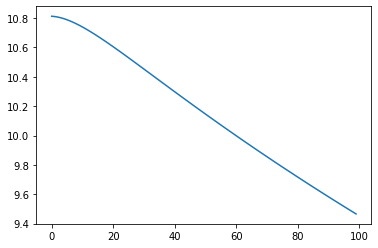

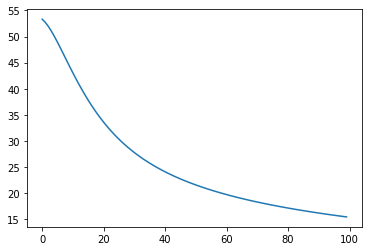

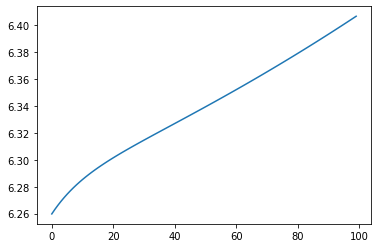

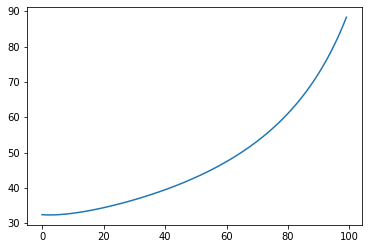

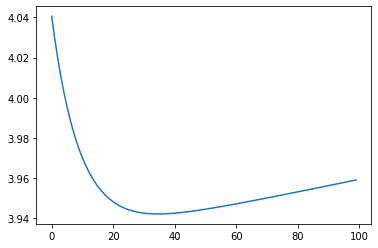

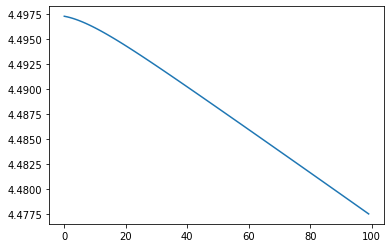

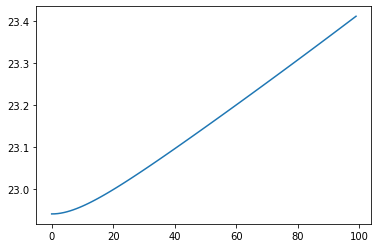

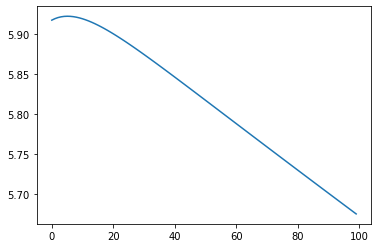

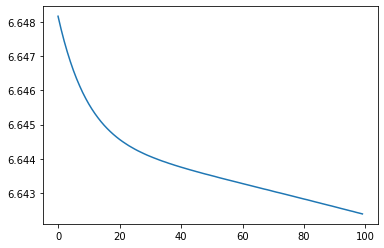

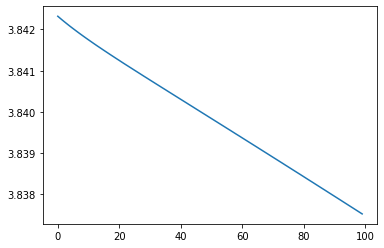

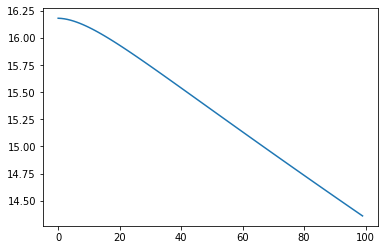

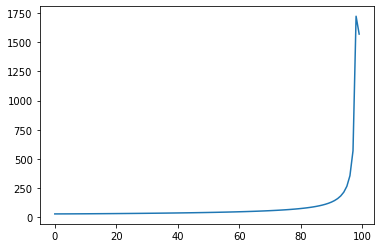

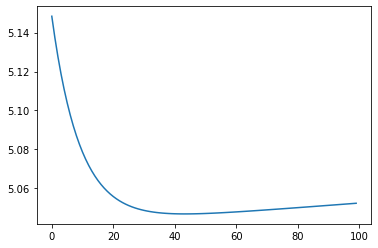

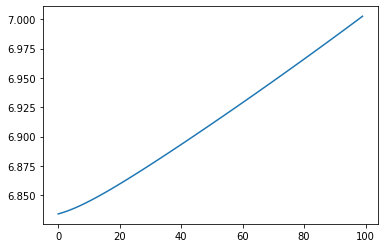

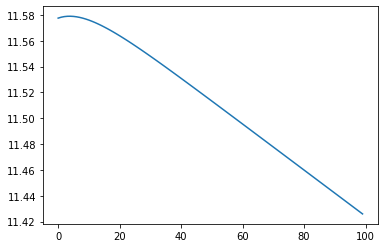

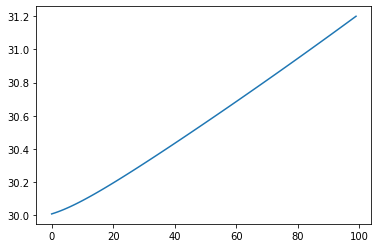

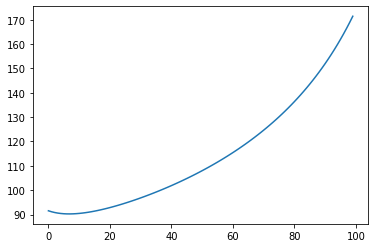

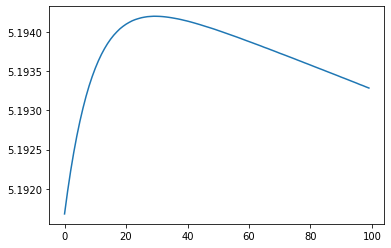

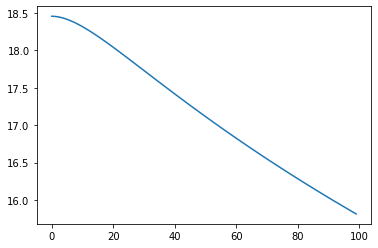

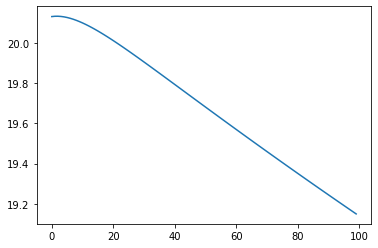

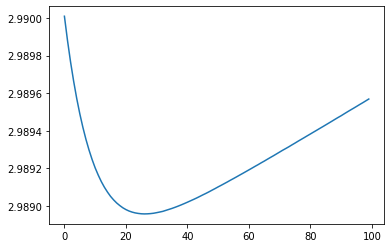

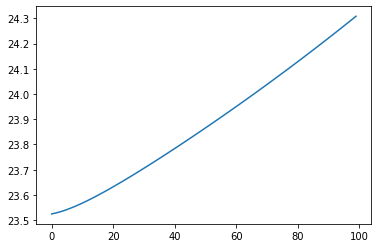

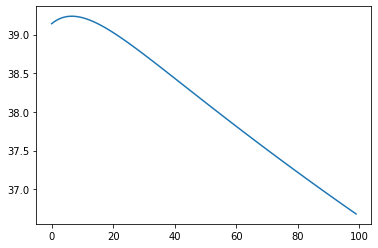

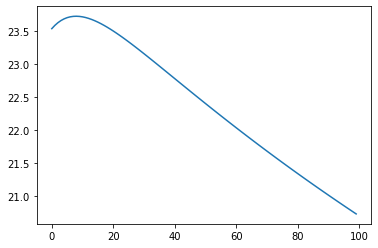

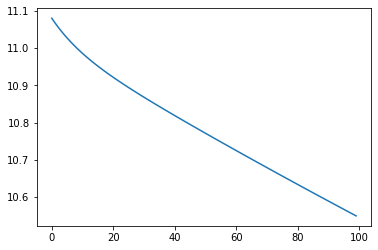

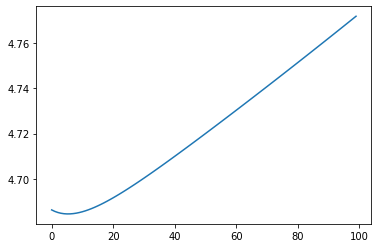

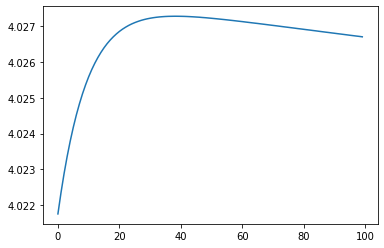

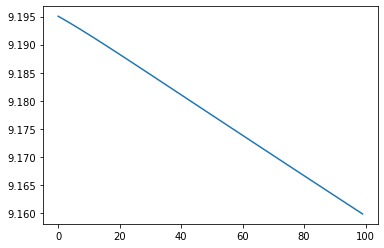

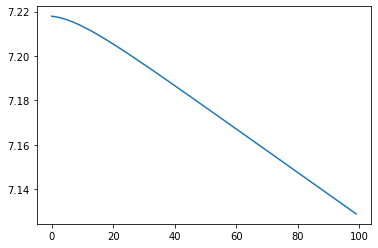

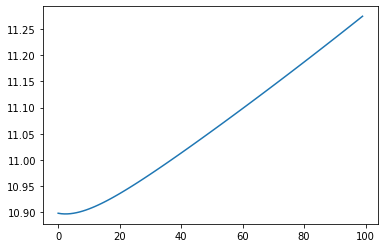

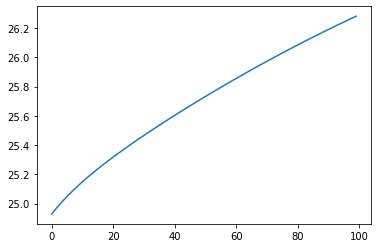

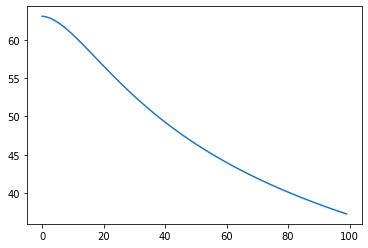

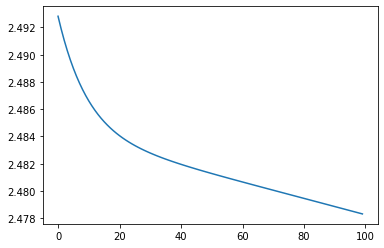

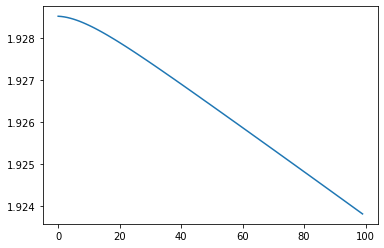

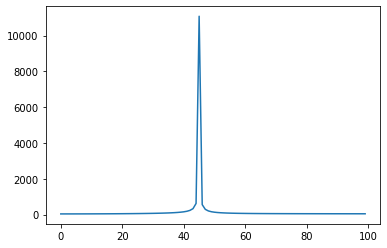

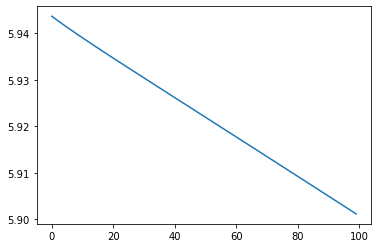

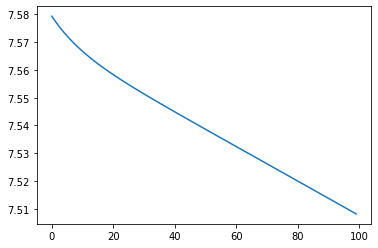

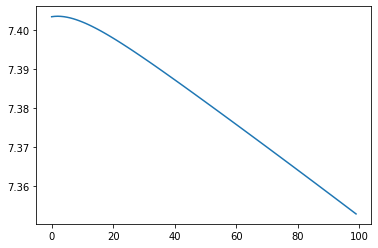

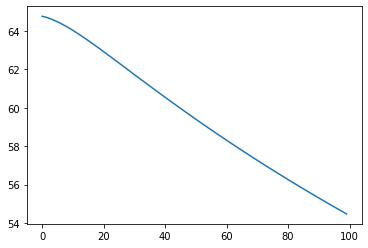

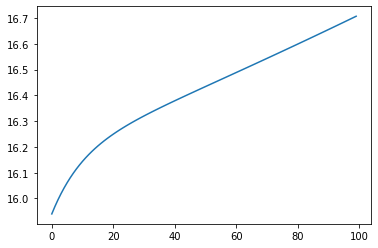

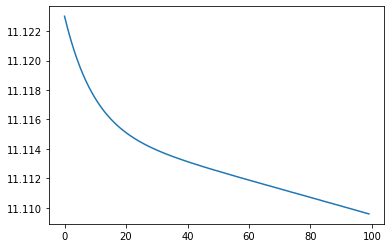

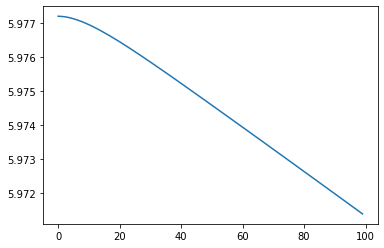

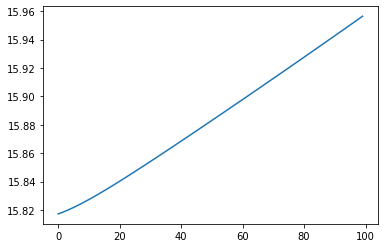

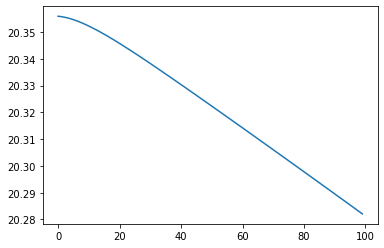

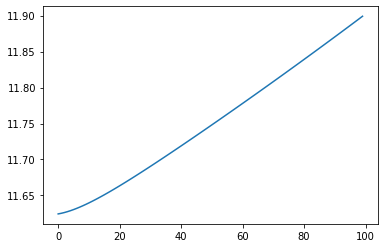

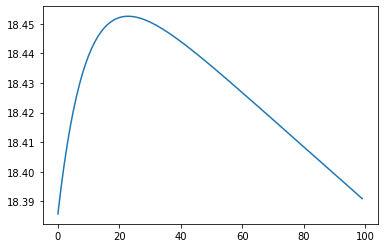

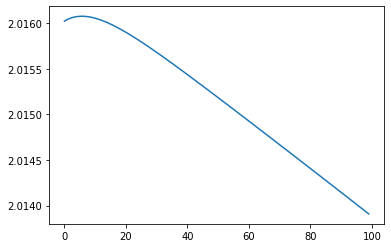

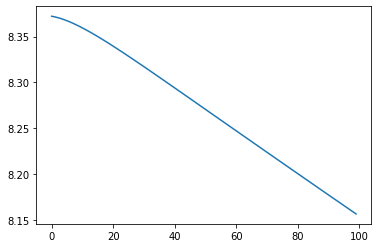

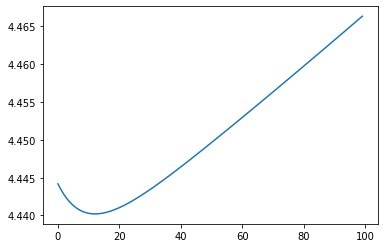

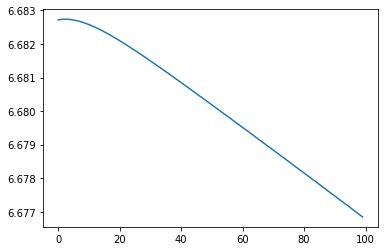

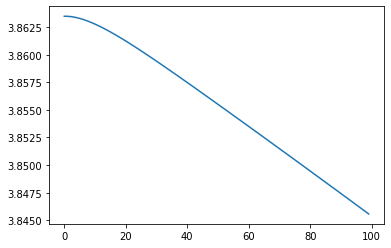

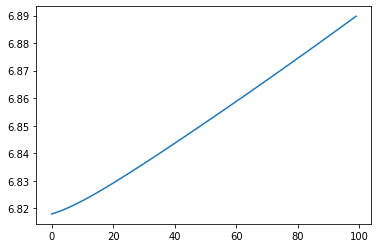

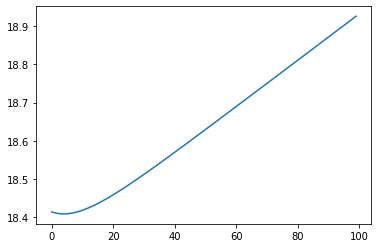

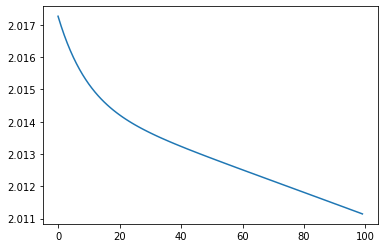

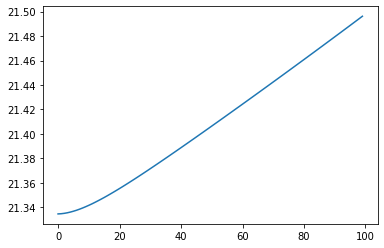

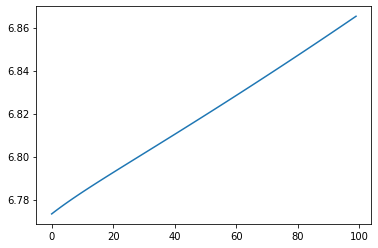

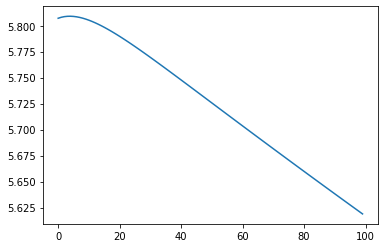

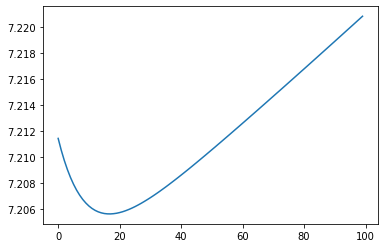

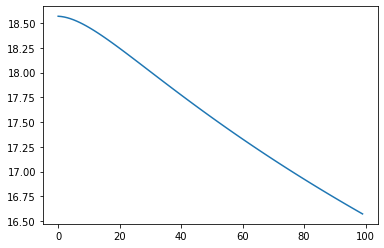

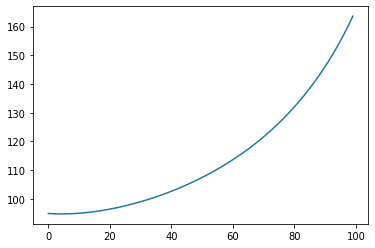

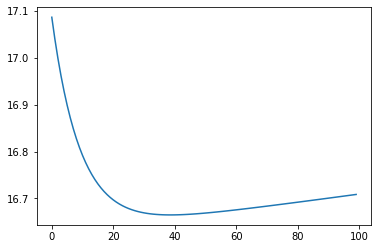

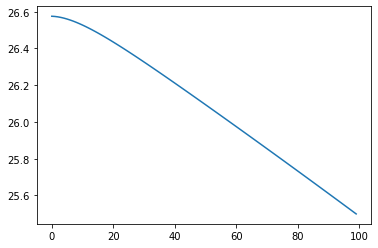

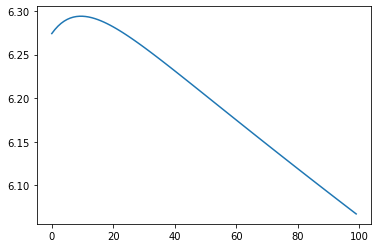

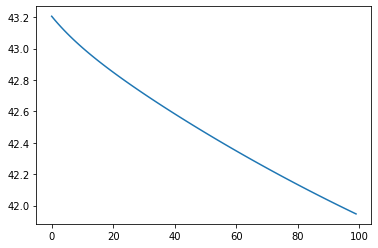

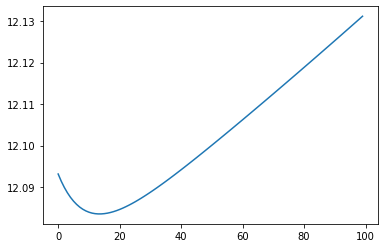

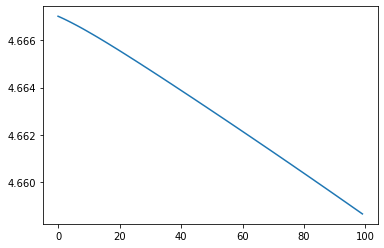

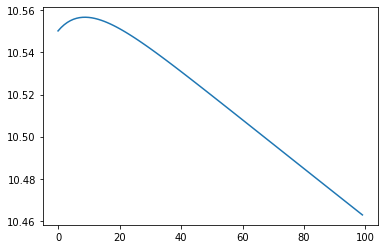

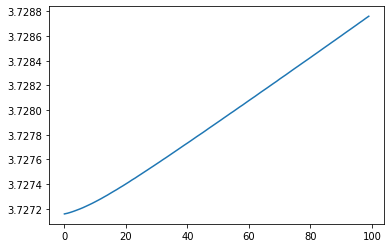

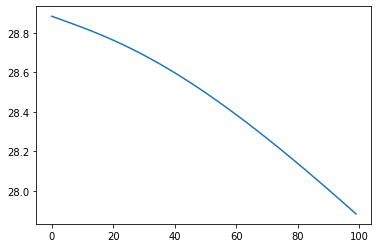

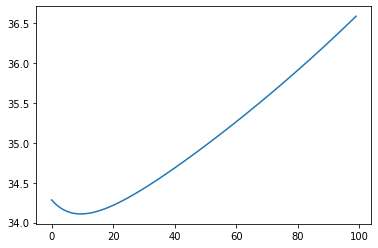

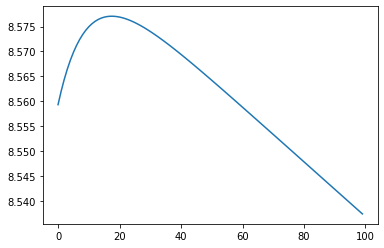

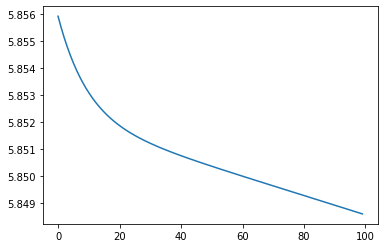

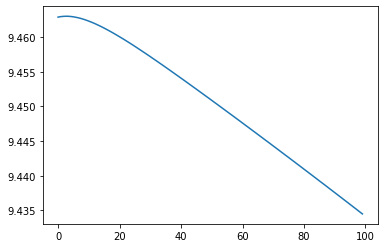

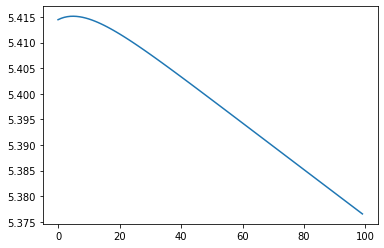

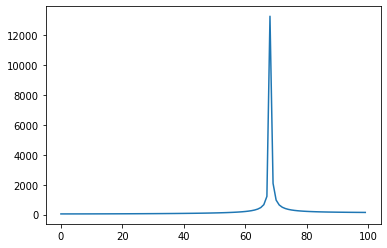

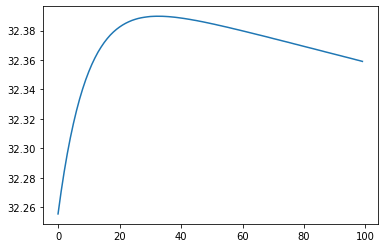

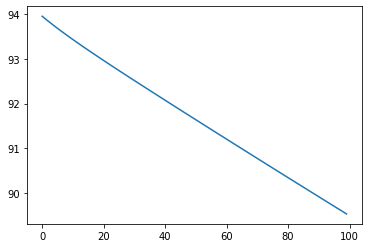

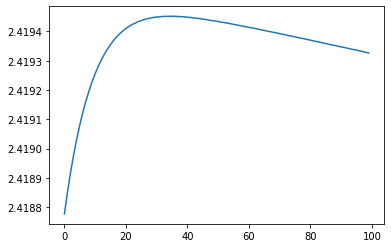

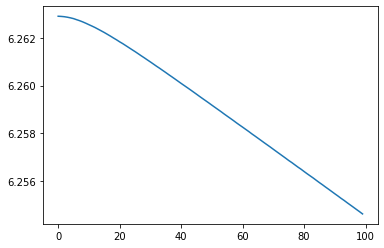

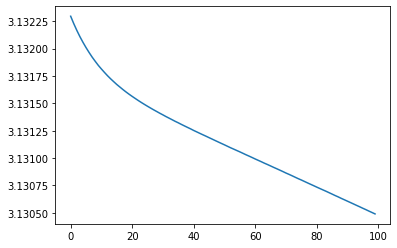

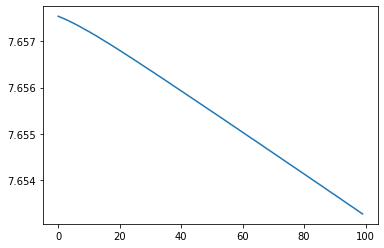

In [ ]:
import matplotlib
x = [i for i in range(len(losses_new_net))]
matplotlib.pyplot.plot(x,losses_new_net)
matplotlib.pyplot.show()
print(len(x)/num_epochs)
for i in range(int(len(x)/num_epochs)):
  x = [i for i in range(len(losses_new_net[i*num_epochs:(i+1)*num_epochs]))]
  matplotlib.pyplot.plot(x,losses_new_net[i*num_epochs:(i+1)*num_epochs])
  matplotlib.pyplot.show()

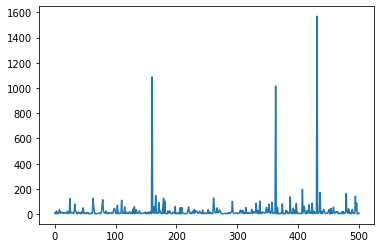

In [ ]:
losses_new_avgd = []
for i in range(int(len(losses_new_net)/num_epochs)):
  losses_new_avgd.append(losses_new_net[num_epochs*(i+1) - 1])

x = [i for i in range(len(losses_new_avgd))]
matplotlib.pyplot.plot(x,losses_new_avgd)
matplotlib.pyplot.show()

## **Hyper Parameter Tuning**


Parameters are Formmated as (TIME_PERIOD_LENGTH, BATCH_SIZE, epochs)

In [ ]:
from collections import defaultdict

In [ ]:
#params = [(30, 30), (45,30), (60,30), (30, 60), (45, 60), (60, 60)]
params = []
time_lengths = [10,20,30,45,60]
batches = [2,3,4,5,10]
epochs = [10,25,50,75,100,125,150,175,200]
for time_len in time_lengths:
  for batch in batches:
    for epoch in epochs:
      params.append((time_len, batch, epoch))
results = defaultdict(list)

In [ ]:
for param in params:
  for _ in range(10):
    TIME_PERIOD_LENGTH, BATCH_SIZE, num_epochs = param
    print(TIME_PERIOD_LENGTH, BATCH_SIZE)
    IEX_TOKEN = "Tpk_647cd93d6c5842d6978e55c6f79b0e1a"

    client = p.Client(api_token = IEX_TOKEN, version='sandbox')
    #testing_len = 0
    #stonks = ['amd','wfc','ge','aapl','aal','hog','f','bac','t','intc']
    stonks = ['vti', 'agg', 'dbc', 'vixy']
    NUM_ASSETS = len(stonks)
    overall_data = []
    training_data = []
    testing_data = []
    min_length = float("inf")
    for symb in stonks:
      data = fetchStockData(client,symb)
      s = buildTimeSeries(data)
      len_data = len(s)
      min_length = min(min_length, len_data)
      overall_data.append(s)

    overall_data = [data[-min_length:] for data in overall_data]

    NUM_FEATURES = NUM_ASSETS * len(overall_data[0][0])

    combined_data = []
    for i,data in enumerate(overall_data[0]):
      combined_data.append([])
      for j in range(NUM_ASSETS):
        combined_data[i].extend(overall_data[j][i])
    d = torch.tensor(combined_data)
    d = PortfolioDataSet(d,TIME_PERIOD_LENGTH,NUM_ASSETS,NUM_FEATURES,BATCH_SIZE)

    class Net(nn.Module):
      def __init__(self):
          super(Net, self).__init__()
          self.input = nn.LSTM(NUM_FEATURES, 64, 1, batch_first = True)
          self.lin = nn.Linear(TIME_PERIOD_LENGTH * 64,NUM_ASSETS)
          self.soft_out = nn.Softmax(dim=1)
      def forward(self, x, batch_len):
          x, (h0, c0) = self.input(x)
          #print("lstm out:",x)
          #print(x.shape)
          x = x.reshape((batch_len, TIME_PERIOD_LENGTH * 64))
          #print("reshape out:",x)
          #print(x[0],x[1])
          #print(x.shape)
          x = self.lin(x)
          #print(x[0],x[1])
          #print("lin out:",x)
          x = self.soft_out(x)
          return x

    overall_val = 1
    start_day = 0
    net = Net().to('cuda')
    losses_new_net = []
    num_epochs = 100
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    loss_fn = sharpe_loss
    total_time = 0
    simulation_day = 0
    for i in range(len(d)):
      start = time.time()
      print("step {}".format(i))
      for epoch in range(num_epochs):
        #print("input:", d[i], "len:", len(d[i]))
        out = net.forward(d[i], len(d[i]))
        #print("out:", out)

        future_index = math.ceil(i + (TIME_PERIOD_LENGTH/BATCH_SIZE))
        if epoch == 0 and simulation_day == 0 and future_index < len(d):
          with torch.no_grad():
            future_index = math.ceil(i + (TIME_PERIOD_LENGTH/BATCH_SIZE))
            sim_out = net.forward(d[future_index], len(d[future_index]))
            weights = sim_out[0].view(NUM_ASSETS)
            percent_change = torch.dot(d.future_returns(future_index)[0], weights)
            overall_val *= 1 + percent_change
            #print("weights:", weights)
            #print("current:", d[i][0][-1].view(NUM_ASSETS, int(NUM_FEATURES/NUM_ASSETS))[:,0], "future:", d.future_returns(i)[0])
            print("return:",overall_val)
        
        loss = loss_fn(out, i, len(d[i]), d.future_returns(i))
        #print("loss:", loss)
        losses_new_net.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      total_time += time.time() - start
      avg_time = total_time/(i + 1)
      print("eta: {}m {}s".format(int(avg_time/60 * (len(d) - i - 1)), int((avg_time * (len(d) - i - 1)) % 60 )))
      simulation_day += len(d[i])
      if simulation_day >= TIME_PERIOD_LENGTH:
        simulation_day = 0

    print(overall_val)
    results[param].append(overall_val.item())
print(results)

Streaming output truncated to the last 5000 lines.
step 336
return: tensor(0.1669)
eta: 0m 25s
step 337
eta: 0m 25s
step 338
eta: 0m 24s
step 339
eta: 0m 24s
step 340
return: tensor(0.3860)
eta: 0m 24s
step 341
eta: 0m 23s
step 342
eta: 0m 23s
step 343
eta: 0m 23s
step 344
return: tensor(0.3138)
eta: 0m 22s
step 345
eta: 0m 22s
step 346
eta: 0m 22s
step 347
eta: 0m 21s
step 348
return: tensor(0.3254)
eta: 0m 21s
step 349
eta: 0m 21s
step 350
eta: 0m 20s
step 351
eta: 0m 20s
step 352
return: tensor(0.2863)
eta: 0m 20s
step 353
eta: 0m 19s
step 354
eta: 0m 19s
step 355
eta: 0m 19s
step 356
return: tensor(0.2487)
eta: 0m 18s
step 357
eta: 0m 18s
step 358
eta: 0m 18s
step 359
eta: 0m 17s
step 360
return: tensor(0.2772)
eta: 0m 17s
step 361
eta: 0m 17s
step 362
eta: 0m 16s
step 363
eta: 0m 16s
step 364
return: tensor(0.2446)
eta: 0m 16s
step 365
eta: 0m 15s
step 366
eta: 0m 15s
step 367
eta: 0m 15s
step 368
return: tensor(0.2307)
eta: 0m 14s
step 369
eta: 0m 14s
step 370
eta: 0m 14s
step 37

# **Building the Net With Batching Input Data and Iterating over All Batches Each Epoch**

In [ ]:
IEX_TOKEN = "Tpk_647cd93d6c5842d6978e55c6f79b0e1a"

client = p.Client(api_token = IEX_TOKEN, version='sandbox')

stonks = ['amd','wfc','ge','aapl','aal','hog','f','bac','t','intc']
#stonks = ['vti', 'agg', 'dbc', 'vixy']
NUM_ASSETS = len(stonks)
overall_data = []
training_data = []
testing_data = []
min_length = float("inf")
for symb in stonks:
  data = fetchStockData(client,symb)
  #c,r = data[0],data[1]
  #s = buildTimeSeries(c,r)
  s = buildTimeSeries(data)
  len_data = len(s)
  min_length = min(min_length, len_data)
  overall_data.append(s)
  #training_data.append(s[:int(0.9*len_data)])
  #testing_data.append(s[int(0.9*len_data):])

overall_data = [data[-min_length:] for data in overall_data]
NUM_FEATURES = NUM_ASSETS * len(overall_data[0][0])

#print(overall_data)
combined_data = []
for i,data in enumerate(overall_data[0]):
  combined_data.append([])
  for j in range(NUM_ASSETS):
    combined_data[i].extend(overall_data[j][i])
combined_data = torch.tensor(combined_data)
print(len(combined_data),len(combined_data[0]))
d = PortfolioDataSet(combined_data,TIME_PERIOD_LENGTH,NUM_ASSETS,NUM_FEATURES,BATCH_SIZE)
#testing_d = PortfolioDataSet(testing_data,TIME_PERIOD_LENGTH)

1258 140


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.input = nn.LSTM(NUM_ASSETS * 2, NUM_ASSETS, 1, batch_first = True)
        self.lin = nn.Linear(TIME_PERIOD_LENGTH * NUM_ASSETS,NUM_ASSETS)
        self.soft_out = nn.Softmax(dim=1)
    def forward(self, x, batch_len):
        x, (h0, c0) = self.input(x)
        #print(x.shape)
        x = x.reshape(batch_len, TIME_PERIOD_LENGTH * NUM_ASSETS)
        #print(x[0],x[1])
        #print(x.shape)
        x = self.lin(x)
        #print(x[0],x[1])
        #print(x)
        x = self.soft_out(x)
        return x

In [ ]:

def sharpe_loss(weights, batch_pos, batch_len):
  total_ratio = 0
  returns = d.non_normal()[batch_pos]
  total_ratio = 0
  er = 0
  er2 = 0
  risk_free_rate = 0.09
  for seq in range(1, batch_len):
    month_data = returns[seq]
    r_i_t = (month_data[TIME_PERIOD_LENGTH - 1].reshape(NUM_ASSETS,2)[:,0]/(month_data[0].reshape(NUM_ASSETS,2)[:,0] - month_data[0].reshape(NUM_ASSETS,2)[:,1])) - 1
    #print("month_data", month_data[TIME_PERIOD_LENGTH - 1].reshape(NUM_ASSETS,2)[:,0], month_data[0].reshape(NUM_ASSETS,2)[:,0] - month_data[0].reshape(NUM_ASSETS,2)[:,1])
    #print("day close/returns:", month_data[0].reshape(NUM_ASSETS,2)[:,0], month_data[0].reshape(NUM_ASSETS,2)[:,1])
    #print("r_i_t", r_i_t)
    #print(r_i_t.shape)
    curr_er = torch.dot(r_i_t, weights[seq - 1])
    er += curr_er
    er2 += curr_er**2
    """
    month_return = month_return/torch.reshape(d[time_period - 1][-1],(NUM_ASSETS,2))[:,0]
    
    er += torch.dot(weights,month_return)
    er2 += torch.dot(weights,month_return)**2
    er_std += torch.std(torch.mul(weights,month_return))
    total_return_by_asset += torch.mul(weights,month_return)
    """
  er = er/(batch_len - 1)
  """
  for day in range(TIME_PERIOD_LENGTH):
    curr_er2 = 0
    for asset in range (NUM_ASSETS):
      curr_er2 += out[asset][day][0] * d[TIME_PERIOD_LENGTH][asset][day][1]
    er2 += curr_er2**2
  er2 = er2/TIME_PERIOD_LENGTH
  """
  #print("er:", er, "er_std:", er_std)
  #ratio = er / er_std
  ratio = (er - risk_free_rate) / torch.sqrt(er2 - er**2)
  #ratio = er / torch.std(total_return_by_asset)
  ratio = -1 * ratio
  return ratio

In [ ]:
#Testing the Sharpe Ratio
"""
example_weights = [0.1] * 10
returns = d[0][0]
return_count = 0
return_total = 0
for day in range(1, len(torch.reshape(returns, (30, 10, 2)))):
  return_total += torch.reshape(returns[day], (10,2))[:,1]/torch.reshape(returns[day - 1], (10,2))[:,0]
  return_count += 1

reshaped = torch.reshape(returns, (30, 10, 2))
print(reshaped[1])
print(reshaped[1:][:,:,1][0])
print((return_total/return_count))
"""

'\nexample_weights = [0.1] * 10\nreturns = d[0][0]\nreturn_count = 0\nreturn_total = 0\nfor day in range(1, len(torch.reshape(returns, (30, 10, 2)))):\n  return_total += torch.reshape(returns[day], (10,2))[:,1]/torch.reshape(returns[day - 1], (10,2))[:,0]\n  return_count += 1\n\nreshaped = torch.reshape(returns, (30, 10, 2))\nprint(reshaped[1])\nprint(reshaped[1:][:,:,1][0])\nprint((return_total/return_count))\n'

In [ ]:
net = Net()
net.cuda()
total_r = 0
total_r2 = 0
num_epochs = 100
losses = []
returns = []
outs = []
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_fn = sharpe_loss
for epoch in range(num_epochs):
  #d.shuffle()
  for i in range(len(d)):
    #print("d[i]",d[i])
    #print(d[i].shape)
    out = net.forward(d[i], len(d[i]))
    if epoch == num_epochs - 1:
      outs.append(out)
    #print(out)
    #print(out.shape)
    #print("weights: ", out)
    #print("shape:", out.shape)
    loss = loss_fn(out, i, len(d[i]))
    losses.append(loss.item())
    print("epoch {} step {} loss:".format(epoch, i), loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


print(out)
"""
for asset in out:
  weights.append(asset[-1][0].item())
print(weights)
"""

RuntimeError: ignored

In [ ]:
def plotReturns(cash,weights,T,batchSize):
    r = returns[:,T:T+batchSize]
    r = torch.transpose(r,0,1)
    R = torch.mul(weights,r)
    R = cash*R
    R = R+cash*weights
    R = torch.sum(R,1)
    print(torch.mean(R))
    plt.plot(R.numpy())

returns = []
ctr = 0
for i,batch in enumerate(reversed(outs)):
  if ctr % 64 == 0:
    returns.append(torch.dot(batch, ))
    ctr = 0

  ctr += 1

#w = torch.tensor([0.2174, 0.0106, 0.0102, 0.3545, 0.0112, 0.0398, 0.0179, 0.1410, 0.0906,
#         0.1069]).reshape(1,10)


#plotReturns(1000,outs,0,64)

In [ ]:
import matplotlib

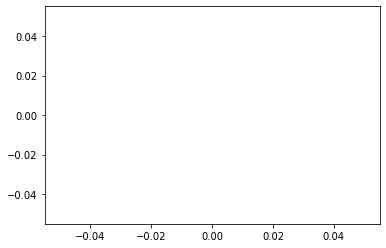

In [ ]:
x = [i for i in range(len(losses))]
matplotlib.pyplot.plot(x,losses)
matplotlib.pyplot.show()

In [ ]:
losses = []
with torch.no_grad():
  for i in range(len(testing_d)):
    #print("d[i]",d[i])
    #print(d[i].shape)
    out = net.forward(testing_d[i], len(testing_d[i]))
    if epoch == num_epochs - 1:
      outs.append(out)
    #print(out)
    #print(out.shape)
    #print("weights: ", out)
    #print("shape:", out.shape)
    loss = loss_fn(out, i, len(testing_d[i]))
    losses.append(loss.item())
    print("epoch {} step {} loss:".format(epoch, i), loss.item())
x = [i for i in range(len(losses))]
matplotlib.pyplot.plot(x,losses)
matplotlib.pyplot.show()

TypeError: ignored

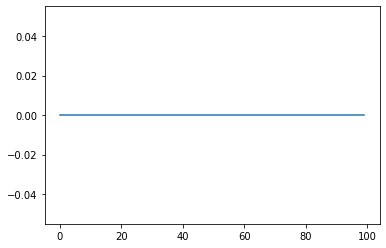

In [ ]:
losses_avgd = []
for i in range(100):
  losses_avgd.append(sum(losses[i*len(d):len(d)*(i+1)])/len(d))

x = [i for i in range(len(losses_avgd))]
matplotlib.pyplot.plot(x,losses_avgd)
matplotlib.pyplot.show()